In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import os
import pandas as pd
from astropy.io import fits
from scipy import interpolate
from scipy import integrate
import matplotlib.cm as cm
import scipy
import scipy.optimize as opt
import astropy.units as u
import astropy.cosmology as cosmo

import sys
sys.path.insert(0, '/Users/mariavincenzi/PhD/Photometry_Utils/')

import what_the_flux as wtf


import george
from george.kernels import ExpSquaredKernel, ConstantKernel, Matern32Kernel
FILTER_PATH = "/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Sullivan_Filters/"
DATALC_PATH = "/Users/mariavincenzi/PhD/pycoco_2/data/"

CSP_SNe = ['SN2004fe', 'SN2005bf', 'SN2006V', 'SN2007C', 'SN2007Y',
           'SN2009bb',  'SN2008aq', 'SN2006T', 'SN2004gq', 'SN2004gt',
           'SN2004gv','SN2006ep', 'SN2008fq', 'SN2006aa']

flux_units = u.erg /(u.cm**2 * u.second * u.Angstrom)
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 13
mpl.rcParams['axes.labelsize'] = 13

final_table = pd.read_csv('/Users/mariavincenzi/PhD/pycoco_2/data/info/FINAL_info.dat')
peak_dicts = dict(zip(final_table.Name.values, np.array(final_table['mjd Lbol peak'].values, dtype=float)))

In [2]:
#w,t=wtf.loadFilter(FILTER_PATH+'Swift/swift_UVW2.dat')
#band = wtf.Band_Vega(w,t)
#
#band.zpFlux() #band.zpCnt()


In [3]:

all_filters=['Bessell_U','Bessell_B','Bessell_V','Bessell_R','Bessell_I',
             'sdss_g','sdss_i','sdss_r','sdss_z','sdss_u','swift_UVW1',
             'swift_UVW2','swift_V', 'swift_U', 'swift_B',
            'DES_g', 'DES_r', 'DES_i', 'DES_z',
            "sdss_g'","sdss_i'","sdss_r'","sdss_z'","sdss_u'"]

des_filters=['DES_g', 'DES_r', 'DES_i', 'DES_z']
lsst_filters=['LSST_LSSTu', 'LSST_LSSTg', 'LSST_LSSTr', 'LSST_LSSTi', 'LSST_LSSTz']

In [4]:
color_dict = {'A':'grey',
              'Bessell_U': 'blue',
              'Bessell_B': 'royalblue',
                'Bessell_V':  'limegreen',
                'Bessell_R':  'red',
                'Bessell_I':  'mediumvioletred',
                'sdss_g':    'darkgreen', "sdss_g'":    'darkgreen',
                'sdss_i':    'indianred', "sdss_i'":    'indianred',
                'sdss_r':    'darkred', "sdss_r'":    'darkred',
                'sdss_z':    'sienna', "sdss_z'":    'sienna',
                'sdss_u': 'darkblue', "sdss_u'": 'darkblue',
                'Y':  'salmon','H':  'darkred', 'J':  'k',
              'Ks':  'brown','K':  'brown',
                'swift_UVW1':'indigo',
                'swift_UVW2':'darkblue',
                'swift_UVM2':'darkmagenta',
                'swift_U':'plum',
                'swift_V':'teal',
                'swift_B':'powderblue',
                'DES_g': "darkgreen",
                 'DES_r': "#F2990A",
                 'DES_i': "red",
                'DES_z': "darkred", 
             'LSST_LSSTu':'m', 
              'LSST_LSSTg':'darkgreen', 
              'LSST_LSSTr':"#F2990A", 
              'LSST_LSSTi':"red", 'LSST_LSSTz':"darkred"}


In [5]:
def calc_lam_eff(wls, transmission):
    return (integrate.trapz(transmission*wls, wls)/\
            integrate.trapz(transmission, wls))

Vega_filters = ['swift_UVW1', 'swift_UVM2', 'swift_UVW2', 'swift_U', 'swift_B', 'swift_V', 
                'Bessell_U', 'Bessell_B', 'Bessell_R', 'Bessell_I', 'Bessell_V', 'J', 'Y', 'H', 'K', 'Ks']
AB_filters = ['sdss_u','sdss_g','sdss_r','sdss_i','sdss_z',"sdss_u'","sdss_g'",
              "sdss_r'","sdss_i'", "sdss_z'", 'DES_g', 'DES_r', 'DES_i', 'DES_z',
              'LSST_LSSTu','LSST_LSSTg', 'LSST_LSSTr', 'LSST_LSSTi', 'LSST_LSSTz']

mycosmo = cosmo.FlatLambdaCDM(H0=70, Om0=0.3)

convert2mjd = (lambda x: float(x.replace('_REmangled_spec.txt','').replace('_REmangled_spec_FL.txt','').replace('_REmangled_spec_SMOOTH.txt','')))


In [6]:
class FinalLC():
    """Class with photometry for each object:
            - load the photometry from the DATA folder
            - get the phootmetry in each filter
            - plot the raw photometry 
            - fit the photometry using GP
    """
    
    def __init__(self, main_path, snname, verbose=False, twodim=False):

        ## Initialise the class variables
        self.main_path = main_path
        self.lc_data_path = main_path+'lc/'
        self.snname = snname   
        self.remangled_spec_data_path = main_path+'/results_template/%s/RE_mangled_spectra_2dim/'%self.snname
        self.FINAL_spec_data_path = main_path+'/results_template/%s/FINAL_spectra_2dim/'%self.snname
        #if twodim else main_path+'/results_template/%s/RE_mangled_spectra_classic/'%self.snname
        
    def load_original_phot(self, verbose = False):
        SNphotometry_PATH = os.path.join(self.main_path+\
                                         '/results_template/%s/fitted_phot_%s.dat'%(self.snname,self.snname))
        lc_file = pd.read_csv(SNphotometry_PATH, delimiter='\t')
        #lc_file = np.genfromtxt(SNphotometry_PATH, names=True, dtype=None,encoding="utf-8")
        self.original_phot = lc_file
        return lc_file

    def load_original_unfitted_phot(self, verbose = False):
        SNphotometry_PATH = os.path.join(self.main_path+\
                                         '/results_template/%s/fitted_phot_%s.dat'%(self.snname,self.snname))
        lc_file = pd.read_csv(SNphotometry_PATH, delimiter='\t')
        #lc_file = np.genfromtxt(SNphotometry_PATH, names=True, dtype=None,encoding="utf-8")
        self.original_phot = lc_file
        return lc_file
    
    def get_spec_list(self, verbose=False, final=False):
        if final:
            if FL_mode:
                onlyfiles = [f for f in os.listdir(self.FINAL_spec_data_path) \
                 if os.path.isfile(os.path.join(self.FINAL_spec_data_path, f)) 
                 if ('.txt' in f)&('SNF' not in f)]#SMOOTH
            else:
                onlyfiles = [f for f in os.listdir(self.FINAL_spec_data_path) \
                             if os.path.isfile(os.path.join(self.FINAL_spec_data_path, f)) 
                         if ('txt' in f)&('SNF' not in f)&('FL' not in f)&('SMOOTH.txt' not in f)]
            return onlyfiles
        else:
            if FL_mode:
                onlyfiles = [f for f in os.listdir(self.remangled_spec_data_path) \
                             if os.path.isfile(os.path.join(self.remangled_spec_data_path, f)) 
                         if ('.txt' in f)&('SNF' not in f)]
            else:
                onlyfiles = [f for f in os.listdir(self.remangled_spec_data_path) \
                             if os.path.isfile(os.path.join(self.remangled_spec_data_path, f)) 
                         if ('txt' in f)&('SNF' not in f)&('FL' not in f)&('SMOOTH.txt' not in f)]#&('FL' not in f)

            return onlyfiles
    
    def load_remangled_spec(self, file_name, final=False):
        if not final:
            ext_spec = np.genfromtxt(self.remangled_spec_data_path+file_name,\
                                     dtype=None, encoding="utf-8", names=['wls', 'flux', 'flux_err'], usecols=[0,1,2])
            return ext_spec
        else:
            ext_spec = np.genfromtxt(self.FINAL_spec_data_path+file_name,\
                                     dtype=None, encoding="utf-8", names=['wls', 'flux', 'flux_err'], usecols=[0,1,2])
            return ext_spec

    
    def band_flux(self, spec_wls_restframe, spec_flux, spec_flux_err, filter_name, z):
        
        spec_wls = spec_wls_restframe*(1.+z)
    
        if 'swift' in filter_name:
            filt_transm = np.genfromtxt(FILTER_PATH+'/Swift/%s.dat'%filter_name,\
                                                 dtype=None, encoding="utf-8", names=['wls', 'flux'])
        elif 'DES' in filter_name:
            filt_transm = np.genfromtxt(FILTER_PATH+'/DES/%s.dat'%filter_name,\
                                                 dtype=None, encoding="utf-8", names=['wls', 'flux'])
        elif 'LSST' in filter_name:
            filt_transm = np.genfromtxt(FILTER_PATH+'/LSST/%s.dat'%filter_name,\
                                                 dtype=None, encoding="utf-8", names=['wls', 'flux'])
        elif self.snname in CSP_SNe:
            try:
                filt_transm = np.genfromtxt(FILTER_PATH+'/Site3_CSP/%s.txt'%filter_name,\
                                                 dtype=None, encoding="utf-8", names=['wls', 'flux'])
                #print ('Im using the CSP NATURAL SYSTEM!!!')
            except IOError:
                filt_transm = np.genfromtxt(FILTER_PATH+'/GeneralFilters/%s.dat'%filter_name,\
                                                 dtype=None, encoding="utf-8", names=['wls', 'flux'])
                
        else:
            filt_transm = np.genfromtxt(FILTER_PATH+'/GeneralFilters/%s.dat'%filter_name,\
                                                 dtype=None, encoding="utf-8", names=['wls', 'flux'])
        
        lam_eff = calc_lam_eff(filt_transm['wls'], filt_transm['flux']) 
        filt_transm_interp_func = interpolate.interp1d(filt_transm['wls'], filt_transm['flux'], kind='linear')
        cut_spec = [(spec_wls>min(filt_transm['wls']))&\
                     (spec_wls<max(filt_transm['wls']))]
        cut_raw_spec_wls = spec_wls[cut_spec]
        cut_raw_spec_flx = spec_flux[cut_spec]
        cut_raw_spec_flx_err = spec_flux_err[cut_spec]

        filt_transm_interp = filt_transm_interp_func(cut_raw_spec_wls)
        filt_transm_interp_xLambda = filt_transm_interp*cut_raw_spec_wls

        raw_phot = integrate.trapz(filt_transm_interp_xLambda*cut_raw_spec_flx, cut_raw_spec_wls)/\
                 integrate.trapz(filt_transm_interp_xLambda, cut_raw_spec_wls)
        raw_phot_err = (integrate.trapz((filt_transm_interp_xLambda*cut_raw_spec_flx_err)**2, 
                                        cut_raw_spec_wls))**0.5/\
                 integrate.trapz(filt_transm_interp_xLambda, cut_raw_spec_wls)
        #raw_phot_err = (integrate.trapz((filt_transm_interp_xLambda*cut_raw_spec_flx_err), 
        #                                cut_raw_spec_wls))/\
        #         integrate.trapz(filt_transm_interp_xLambda, cut_raw_spec_wls)

        #print (raw_phot, raw_phot_err, 'SN', raw_phot/raw_phot_err)
        #plt.plot(cut_raw_spec_wls, cut_raw_spec_flx)
        #plt.fill_between(cut_raw_spec_wls, cut_raw_spec_flx-cut_raw_spec_flx_err,
        #                cut_raw_spec_flx+cut_raw_spec_flx_err, alpha=0.2)
        #plt.title('cut_raw_spec_flx')
        #plt.show()
        #plt.plot(cut_raw_spec_wls, filt_transm_interp_xLambda*cut_raw_spec_flx)
        #plt.title(' filt_transm_interp_xLambda*cut_raw_spec_flx ')
        #plt.show()
        #plt.plot(cut_raw_spec_wls, filt_transm_interp_xLambda*cut_raw_spec_flx_err)
        #plt.title(' filt_transm_interp_xLambda*cut_raw_spec_flx_err ')
        #plt.show()
        #print ('integral', integrate.trapz(filt_transm_interp_xLambda, cut_raw_spec_wls))

        return raw_phot, raw_phot_err
    
    def get_remangled_photometry(self, z, f_list, final=False):
        dicts_LC_raw = {}
        spec_list = self.get_spec_list(final=final)
        
        for band in f_list:
            LC_raw = []
            LC_raw_err = []
            for file in (spec_list):
                remang_spec = self.load_remangled_spec(file, final=final)
                phot, phot_err = self.band_flux(remang_spec['wls'], remang_spec['flux'], 
                                                remang_spec['flux_err'], band, z)
                LC_raw.append(phot)
                LC_raw_err.append(phot_err)

            dicts_LC_raw[band] = {'z':z, 'time': (self.get_spec_mjd()), \
                                'flux': LC_raw, 'flux_err': LC_raw_err}
            print (len(self.get_spec_mjd()), len(LC_raw), len(LC_raw_err))
        self.dicts_LC_raw = dicts_LC_raw
        return dicts_LC_raw

    def get_spec_mjd(self):
        return np.array([convert2mjd(f) for f in self.get_spec_list()])#

    def get_spec_mjd_fake(self):
        return np.array([convert2mjd(f) for f in self.get_spec_list() if 'FL.txt' in f])#

    def get_avail_filt(self):
        lista = [band for band in self.original_phot.columns if ('_err' not in band)&('MJD' not in band)]
        self.avail_filters = lista
        return lista
        
    def LCfit_withGP_xfilter(self, filt, z, f_list, final=False, minMJD=None, maxMJD=None):
        if not hasattr(self, "dicts_LC_raw"):
            self.get_remangled_photometry(z, f_list, final=final)
        elif self.dicts_LC_raw[filt]['z']!=z:
            self.get_remangled_photometry(z, f_list, final=final)
        
        def ll(p):
            gp.set_parameter_vector(p)
            param_dict = gp.get_parameter_dict()
            if 'white_noise:value' in param_dict.keys():
                if (np.exp(param_dict['white_noise:value'])<10**-3): 
                    return np.inf
                else: return -gp.lnlikelihood(flux_norm, quiet=False)#
            else: return -gp.lnlikelihood(flux_norm, quiet=False)#

        # gradient of the  liklihood for optimisation of the kernel size

        def grad_ll(p):
            gp.set_parameter_vector(p)
            return -gp.grad_lnlikelihood(flux_norm, quiet=False)
            
        #first_filt = list(self.dicts_LC_raw.keys())[0]
        #mjd_g_peak = self.dicts_LC_raw[first_filt]['time'][np.argmax(self.dicts_LC_raw[first_filt]['flux'])]
        #
        #if minMJD is None:
        #    minMJD= min([mjd_g_peak-15.,np.min(self.dicts_LC_raw[first_filt]['time'])])
        #if maxMJD is None:
        #    maxMJD= max([mjd_g_peak+90.,np.max(self.dicts_LC_raw[first_filt]['time'])])
        #new_mjd = np.arange(minMJD, maxMJD, 0.5)
        
        LC_filt_extended = self.dicts_LC_raw[filt]

        flux_nan = (LC_filt_extended['flux'])
        flux = np.array(flux_nan)[~np.isnan(flux_nan)]
        flux_err = np.array(LC_filt_extended['flux_err'])[~np.isnan(flux_nan)]
        mjd = np.array(LC_filt_extended['time'])[~np.isnan(flux_nan)]
        #mjdT = np.atleast_2d(mjd).T
        
        #norm = np.median(flux) #np.median(LC_filt_extended['flux']) 
        #flux_norm = flux/norm
        #err_flux_norm = flux_err/norm
        #
        #if self.snname in Kernel_wNoise_wOpt:
        #    k= np.var(flux_norm)* Matern32Kernel(350.)
        #    gp = george.GP(k, white_noise=10**-10, fit_white_noise=True, fit_kernel=True)
        #elif self.snname in Kernel_noNoise_wOpt:
        #    k= np.var(flux_norm)* Matern32Kernel(50.)
        #    gp = george.GP(k, fit_kernel=True)
        #elif self.snname in Kernel_noNoise_noOpt:
        #    k= np.var(flux_norm)* ExpSquaredKernel(500.)
        #    gp = george.GP(k, fit_kernel=False)
        #elif self.snname in Kernel_wNoise_noOpt_LongScale:
        #    k= np.var(flux_norm)* Matern32Kernel(400.)
        #    gp = george.GP(k, white_noise=10**-10, fit_white_noise=True, fit_kernel=False)
        #else:
        #    print ('Specify Kernel')
    #print ('log_M_0_0', np.exp(param_dict['kernel:k1:k2:metric:log_M_0_0']))
    ##print ('log_M_1_1', np.exp(param_dict['kernel:k1:k2:metric:log_M_1_1']))
    #if ((np.exp(param_dict['kernel:k1:k2:metric:log_M_0_0'])<0.00001)|(np.exp(param_dict['kernel:k1:k2:metric:log_M_1_1'])<0.00001)):
    #    print ('No good')
    #    return -np.inf

        #gp.compute(mjdT, err_flux_norm)
        #if self.snname not in Kernel_noNoise_noOpt:
        #    p0=gp.get_parameter_vector()
        #    results = opt.minimize(ll, p0, jac=grad_ll)
        #    print (filt, np.exp(results.x))
        #if 'DES' in filt:
        #    for n,v in zip(gp.get_parameter_names(), gp.get_parameter_vector()):
        #        if n=='white_noise:value': print (n, '%.2E'%np.exp(v))
        #
        ##plt.errorbar(mjd, flux_norm, err_flux_norm)
        ##plt.show()
        #
        #mu, cov = gp.predict(flux_norm, new_mjd)
        #std = np.sqrt(np.diag(cov))
        ##mu = (mu*norm)
        ##std =  (std*norm)
        #        
        ##flux = (flux_norm*norm)
        ##err_flux =  (err_flux_norm*norm)

        #Flux = (mu*norm)
        #err_Flux = (std*norm)

        self.dicts_LC_gp[filt] = {'z':z, 'time':mjd, 'flux':flux, 'flux_err':flux_err}
        return None

    def define_filters2fit(self, f_list=[]):
        if len(f_list)>0:
            self.avail_filters = f_list
        else:
            self.avail_filters = ['DES_g', 'DES_r', 'DES_i', 'DES_z']

    def LCfit_withGP(self, z, f_list=None, final=False, minMJD=None, maxMJD=None):
        if not hasattr(self, "dicts_LC_gp"):
            print ('Computing GP fit (for the first time)')
        else:
            print ('Forcing to do GP fit again')
        
        if not hasattr(self, "avail_filters"):
            self.define_filters2fit(f_list)

        self.dicts_LC_gp = {}
        for f in f_list:
            print ('Interpolating with GPs ', f, 'final', final)
            self.LCfit_withGP_xfilter(f, z, f_list, final=final, minMJD=minMJD, maxMJD=maxMJD)
        return self.dicts_LC_gp
        
        
    def save_plot_GPfit(self, f_list, save_fig_output=None):
        if not hasattr(self, "results_mainpath"):
            self.create_results_folder()

        if not hasattr(self, "dicts_LC_gp"):
            self.LCfit_withGP(z, f_list=f_list)
        
        redshift = (self.dicts_LC_gp[f_list[0]]['z'])
        
        if redshift>0:
            dist = 10**(mycosmo.distmod(redshift).value/5.+1)
            to_app_lum = (dist/10.)**2
        else: to_app_lum = 1.

        max_flux = [10**-20]
        minMag = 10**3
        maxMag = -10**3
        
        fig = plt.figure(figsize=(8,5))
        for f in f_list:
            c = color_dict[f]
            z = self.dicts_LC_raw[f]['z']
            
            mask_fake = [t in self.get_spec_mjd_fake() for t in self.dicts_LC_raw[f]['time']]

            raw_phot = np.array(self.dicts_LC_raw[f]['flux']) / to_app_lum
            raw_phot_std = np.array(self.dicts_LC_raw[f]['flux_err']) / to_app_lum
            
            peak_mjd = peak_dicts[self.snname]
            mjd = (self.dicts_LC_raw[f]['time']-peak_mjd)*(1.+z)+peak_mjd
            phase = (self.dicts_LC_raw[f]['time']-peak_mjd)*(1.+z)
            
            #new_mjd = (self.dicts_LC_gp[f]['time']-peak_mjd)*(1.+z) 
            #mu = self.dicts_LC_gp[f]['flux'] / to_app_lum
            #std = self.dicts_LC_gp[f]['flux_err'] / to_app_lum
            
            linest = '-' if FL_mode else 'None'
            linewid = 0.3 if FL_mode else 1

            #plt.subplot(121)
            #plt.errorbar(mjd, raw_phot, yerr=raw_phot_std, marker='.', ms=8,
            #             mfc=color_dict[f], mec=color_dict[f], ecolor=color_dict[f], 
            #             lw=linewid, linestyle=linest, color=color_dict[f], label=f)
            #plt.errorbar(mjd[mask_fake], raw_phot[mask_fake], yerr=raw_phot_std[mask_fake], marker='.',ms=8,
            #             mfc='white', mec=color_dict[f], mew=0.4, ecolor=color_dict[f],
            #             lw=linewid, linestyle='None')
            #if not FL_mode:
            #    plt.plot(new_mjd, mu, color=color_dict[f], label=f)
            #    plt.fill_between(new_mjd, (mu+std), (mu-std), color=color_dict[f], alpha=0.2)
            
            #plt.subplot(122)
            if 'DES' in f: filt_w, filt_t = wtf.loadFilter(FILTER_PATH+'DES/%s.dat'%f)
            elif 'PS' in f: filt_w, filt_t = wtf.loadFilter(FILTER_PATH+'PS1/%s.txt'%f)
            elif 'LSST' in f: filt_w, filt_t = wtf.loadFilter(FILTER_PATH+'LSST/%s.dat'%f)
            else: filt_w, filt_t = wtf.loadFilter(FILTER_PATH+'GeneralFilters/%s.dat'%f)
            if f in Vega_filters:
                band = wtf.Band_Vega(filt_w, filt_t)
                label='Vega system'
            elif f in AB_filters:
                band = wtf.Band_AB(filt_w, filt_t)
                label='AB system'
                
            mag_phot = wtf.flux2mag(band, raw_phot*flux_units)
            mag_phot_err = wtf.ERRflux2ERRmag(band, raw_phot*flux_units, raw_phot_std*flux_units)
            minMag = min([min(mag_phot[~np.isnan(mag_phot)]), minMag])
            maxMag = max([max(mag_phot[~np.isnan(mag_phot)]), maxMag])
            f_label= f.replace('LSST_LSST','LSST ').replace('DES_','DES ')+' band'
            plt.errorbar(mjd, mag_phot, yerr=mag_phot_err, marker='.',ms=8,
                         mfc=color_dict[f], mec=color_dict[f], ecolor=color_dict[f], 
                         lw=linewid, linestyle=linest, color=color_dict[f], 
                         label=f_label)
            plt.errorbar(mjd[mask_fake], mag_phot[mask_fake], yerr=mag_phot_err[mask_fake], marker='.',ms=8,
                         mfc='white', mec=color_dict[f], mew=0.4, ecolor=color_dict[f], 
                         lw=linewid, linestyle='None')
            plt.grid()

            #if not FL_mode:
            #    mag_phot_fit = wtf.flux2mag(band, mu*flux_units)
            #    mag_phot_fit_err = wtf.ERRflux2ERRmag(band, mu*flux_units, std*flux_units)
            #    plt.plot(new_mjd, mag_phot_fit, color=color_dict[f], label=f)
            #    plt.fill_between(new_mjd, (mag_phot_fit+mag_phot_fit_err), (mag_phot_fit-mag_phot_fit_err),
            #        color=color_dict[f], alpha=0.2)

        detect_mjd = mjd[mag_phot<28]
        if len(detect_mjd)<1: max_detect=0
        else: max_detect = max(detect_mjd)
        max_mjd = max(max_detect,100)
                    
        #plt.subplot(121)
        #plt.legend(fontsize=11, loc='best', fancybox=True, framealpha=0.5)
        #plt.title('%s @ z=%.1f'%(self.snname, z))
        #plt.ylabel('Flux (erg s-1 cm-2 AA-1)')
        #plt.ylim(0,)
        #plt.xlim(min(mjd)-10,max_mjd)#
        
        #plt.subplot(122)
        
        if 'DES' in f_list[0]: survey='DES'
        if 'LSST' in f_list[0]: survey='LSST'
        else: survey=''

        if survey=='DES':
            plt.hlines([25.2, 25.4, 25.1, 24.9], min(mjd), max(mjd),
                   linestyle='--', lw=0.5, color='grey', label='DES Deep Field\nsensitivity')
            for filt,lim in zip(['DES_g', 'DES_r', 'DES_i', 'DES_z'], [25.2, 25.4, 25.1, 24.9]):
                plt.hlines(lim, min(mjd), max(mjd),
                   linestyle='--', lw=0.5, color=color_dict[filt])
        elif survey=='LSST':
            plt.hlines([28., 29.2, 29.4, 28.7, 27.9], min(mjd), max(mjd),
                   linestyle='--', lw=0.5, color='grey', label='LSST Deep Drilling\nField sensitivity')
            for filt,lim in zip(['LSST_LSSTu', 'LSST_LSSTg', 'LSST_LSSTr', 'LSST_LSSTi','LSST_LSSTz'],
                                [28., 29.2, 29.4, 28.7, 27.9]):
                plt.hlines(lim, min(mjd), max(mjd),
                   linestyle='--', lw=0.5, color=color_dict[filt])
        else:
            pass
        plt.ylim(min(32,maxMag),minMag-0.3)#
        
       # plt.ylim(32,minMag-0.3)#

        #plt.ylim(maxMag,minMag-0.3)
        #plt.xlim(min(mjd)-10,max_mjd)#

        plt.legend(fontsize=12, loc='upper right', ncol=2, 
                   fancybox=True, framealpha=0.5)
        plt.ylabel('Apparent Magnitudes ('+label+')',fontsize=14)
        plt.xlabel('Phase', fontsize=14)#plt.xlabel(r'Days since $L_{BVRI}$ Maximum')
        plt.title('%s: Synthetic Lightcurve @ z=%.1f'%(self.snname, z), fontsize=15)
        
        plt.show()
        if save_fig_output is None:
            if FL_mode:
                fig.savefig(self.results_mainpath+'%s_fittedLC_%s_%i_FL.pdf'%(survey, self.snname, 10*z), bbox_inches='tight')
            else:
                fig.savefig(self.results_mainpath+'%s_fittedLC_%s_%i.pdf'%(survey, self.snname, 10*z), bbox_inches='tight')
        else:
            fig.savefig(save_fig_output, bbox_inches='tight')
        return None
        
    def create_results_folder(self):
        results_directory = self.main_path+'/results_template/%s/'%self.snname
        if not os.path.exists(results_directory):
            os.makedirs(results_directory)
        self.results_mainpath = results_directory

    def get_Mpeak_Rband(self):
        if not hasattr(self, "dicts_LC_gp"):
            self.LCfit_withGP(0., ['BessellR'])
        elif 'BessellR' not in list(LC.dicts_LC_gp.keys()):
            self.LCfit_withGP(0., ['BessellR'])
        elif self.dicts_LC_gp['BessellR']['z']!=0.0:
            self.LCfit_withGP(0., ['BessellR'])
        
        f0R_vega= 217.7*10**-11
        fpeakR = 2.91029280167491e-15
        mRvega = -2.5*np.log10(fpeakR/f0R_vega)
        mRAB = mRvega+0.21
        return mRAB

In [9]:
Kernel_wNoise_wOpt = ['SN2013df', 'SN2012ap', 'SN2004fe', 'SN2011bm','SN2005cs','SN2008aq','SN2007pk','SN2007uy']
Kernel_noNoise_wOpt = ['SN2007Y', 'SN2011ei', 'SN2011hs', 'SN2011fe','SN2013am']
Kernel_noNoise_noOpt = []

Kernel_wNoise_noOpt_LongScale = ['SN2006aj', 'SN2013fs', 'SN2014G', 'SN2013ge', 'SN1998bw', 
                                 'SN2011dh', 'SN2013ej', 'SN2009ip', 'SN2008ax','SN2009bb',
                                  'SN2007gr', 'iPTF13bvn', 'SN2009mg', 'SN1993J', 'SN2013am',
                                'SN2012aw', 'SN1994I','SN2010al', 'SN2013ab','SN2009jf','SN2004fe','SN2002ap',
                                'SN2009N', 'SN1999em', 'SN2004et', 'SN2013by', 'SN2006bp', 'SN2007od',
                                 'SN2008in', 'SN2006T', 'SN2004gq','SN2008bj', 'SN2008fq', 'SN2009bw',
                                 'SN2004gv','SN2004gt','SN2009dd','SN2012A','SN2016gkg','SN1999dn', 
                                 'SN2005bf', 'SN2005hg','SN2007ru', 'SN2008D', 'SN2006ep','SN2006aa','SN2016X',
                                'SN2011fu', 'SN2016bkv', 'SN2011ht', 'SN2012ap', 
                                 'SN2013bynouv','SN2010alnouv','iPTF13bvnnouv']

SN_lista_II = ['SN2013by','SN2014G','ASASSN15oz','SN2007od','SN2013ej','SN2013fs','SN2008bj',
'SN2016X','SN2013ab','SN2009bw','SN2012aw','SN2008in','SN2004et','SN2009dd',
'SN1999em','SN2009kr','ASASSN14jb','SN2012A','SN2009ib','SN2013am','SN2016bkv','SN2009N',
'SN2005cs', 'SN2008fq', 'SN2007pk', 'SN2010al', 'SN2009ip', 'SN2006aa', 
               'SN2011ht','SN2013bynouv']

SN_lista_Ib = ['SN1993J', 'SN2006T', 'SN2008aq', 'SN2008ax', 'SN2008bo', 'SN2011dh', 
               'SN2011ei', 'SN2011fu', 'SN2011hs', 'SN2013df','SN2016gkg', 
               'SN1999dn', 'SN2004gq', 'SN2004gv', 'SN2005bf',
               'SN2005hg', 'SN2006ep',  'SN2007Y', 'SN2007uy',  'SN2008D', 'SN2009iz',
               'SN2009jf', 'SN2012au','iPTF13bvn', 'SN1994I','SN2004aw','SN2004fe',
               'SN2004gt','SN2007gr','SN2011bm','SN2013ge','SN1998bw','SN2002ap','SN2006aj',
               'SN2007ru','SN2009bb', 'SN2012ap']

sn_type_lista = [('ASASSN14jb', 'II'),
 ('ASASSN15oz', 'II'),
 ('SN1993J', 'IIb'),
 ('SN1994I', 'Ic'),
 ('SN1998bw', 'Ic-BL'),
 ('SN1999dn', 'Ib'),
 ('SN1999em', 'II'),
 ('SN2002ap', 'Ic-BL'),
 ('SN2004aw', 'Ic'),
 ('SN2004et', 'II'),
 ('SN2004fe', 'Ic'),
 ('SN2004gq', 'Ib'),
 ('SN2004gt', 'Ic'),
 ('SN2004gv', 'Ib'),
 ('SN2005bf', 'Ib'),
 ('SN2005cs', 'II'),
 ('SN2005hg', 'Ib'),
 ('SN2006T', 'IIb'),
 ('SN2006aa', 'IIn'),
 ('SN2006aj', 'Ic-BL'),
 ('SN2006ep', 'Ib'),
 ('SN2007Y', 'Ib'),
 ('SN2007gr', 'Ic'),
 ('SN2007od', 'II'),
 ('SN2007pk', 'IIn'),
 ('SN2007ru', 'Ic-BL'),
 ('SN2007uy', 'Ib'),
 ('SN2008D', 'Ib'),
 ('SN2008aq', 'IIb'),
 ('SN2008ax', 'IIb'),
 ('SN2008bj', 'II'),
 ('SN2008bo', 'IIb'),
 ('SN2008fq', 'IIn'),
 ('SN2008in', 'II'),
 ('SN2009N', 'II'),
 ('SN2009bb', 'Ic-BL'),
 ('SN2009bw', 'II'),
 ('SN2009dd', 'II'),
 ('SN2009ib', 'II'),
 ('SN2009ip', 'IIn'),
 ('SN2009iz', 'Ib'),
 ('SN2009jf', 'Ib'),
 ('SN2009kr', 'II'),
 ('SN2010al', 'IIn'),
 ('SN2011bm', 'Ic'),
 ('SN2011dh', 'IIb'),
 ('SN2011ei', 'IIb'),
 ('SN2011fu', 'IIb'),
 ('SN2011hs', 'IIb'),
 ('SN2011ht', 'IIn'),
 ('SN2012A', 'II'),
 ('SN2012ap', 'Ic-BL'),
 ('SN2012au', 'Ib'),
 ('SN2012aw', 'II'),
 ('SN2013ab', 'II'),
 ('SN2013am', 'II'),
 ('SN2013by', 'II'),
 ('SN2013df', 'IIb'),
 ('SN2013ej', 'II'),
 ('SN2013fs', 'II'),
 ('SN2013ge', 'Ic'),
 ('SN2014G', 'II'),
 ('SN2016X', 'II'),
 ('SN2016bkv', 'II'),
 ('SN2016gkg', 'IIb'),
 ('iPTF13bvn', 'Ib'),
 ('SN2013bynouv', 'II')]

sn_type_lista=  [
# ('iPTF13bvn', 'Ib'),
# ('SN2013am', 'II'),
('SN2011ht', 'IIn')]
# ('SN2002ap', 'Ic-BL')]



Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
100 100 100
100 100 100
100 100 100
100 100 100
100 100 100
100 100 100
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


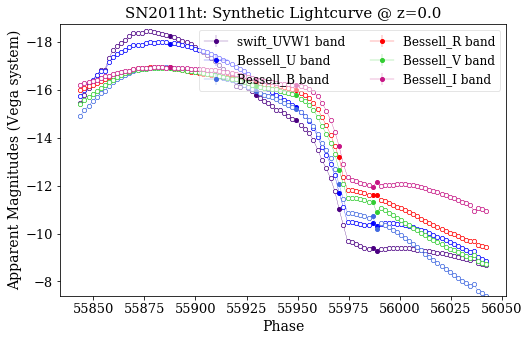

Computing GP fit (for the first time)
Interpolating with GPs  LSST_LSSTu final True
100 100 100
100 100 100
100 100 100
100 100 100
100 100 100
Interpolating with GPs  LSST_LSSTg final True
Interpolating with GPs  LSST_LSSTr final True
Interpolating with GPs  LSST_LSSTi final True
Interpolating with GPs  LSST_LSSTz final True


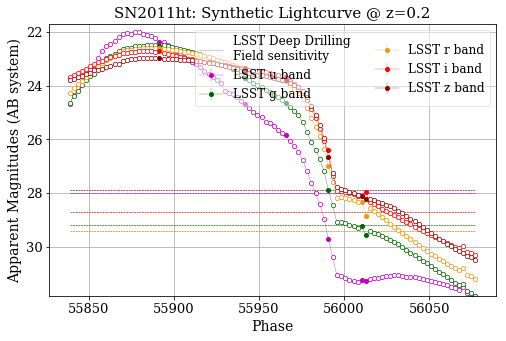

Computing GP fit (for the first time)
Interpolating with GPs  LSST_LSSTu final True
100 100 100
100 100 100
100 100 100
100 100 100
100 100 100
Interpolating with GPs  LSST_LSSTg final True
Interpolating with GPs  LSST_LSSTr final True
Interpolating with GPs  LSST_LSSTi final True
Interpolating with GPs  LSST_LSSTz final True


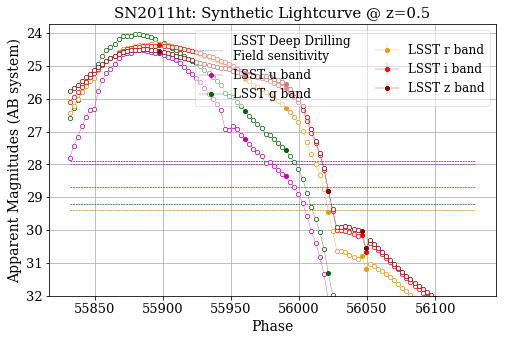

Computing GP fit (for the first time)
Interpolating with GPs  LSST_LSSTu final True
100 100 100
100 100 100
100 100 100
100 100 100
100 100 100
Interpolating with GPs  LSST_LSSTg final True
Interpolating with GPs  LSST_LSSTr final True
Interpolating with GPs  LSST_LSSTi final True
Interpolating with GPs  LSST_LSSTz final True


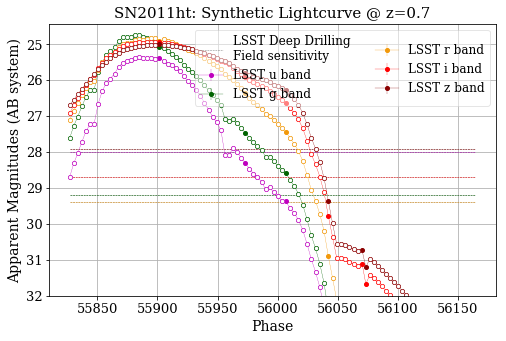

In [11]:
for snname,typ in sn_type_lista:
    FL_mode=True
    LC = FinalLC(main_path=DATALC_PATH, snname=snname, twodim=True)
    dicts_LC_gp = LC.LCfit_withGP(0.0, f_list=['swift_UVW1', 'Bessell_U','Bessell_B', 'Bessell_R', 'Bessell_V', 'Bessell_I'], final=True)
    LC.save_plot_GPfit(f_list=['swift_UVW1','Bessell_U','Bessell_B', 'Bessell_R', 'Bessell_V', 'Bessell_I'])
    for zz in [0.2,0.5,0.7]: 
        LC = FinalLC(main_path=DATALC_PATH, snname=snname, twodim=True)
        dicts_LC_gp = LC.LCfit_withGP(zz, f_list=lsst_filters, final=True)
        LC.save_plot_GPfit(f_list=lsst_filters)

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
103 103 103
103 103 103
103 103 103
103 103 103
103 103 103
103 103 103
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


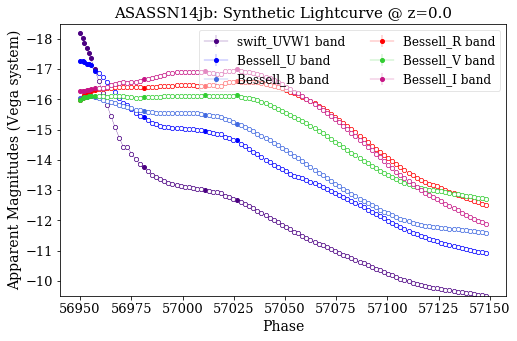

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
104 104 104
104 104 104
104 104 104
104 104 104
104 104 104
104 104 104
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


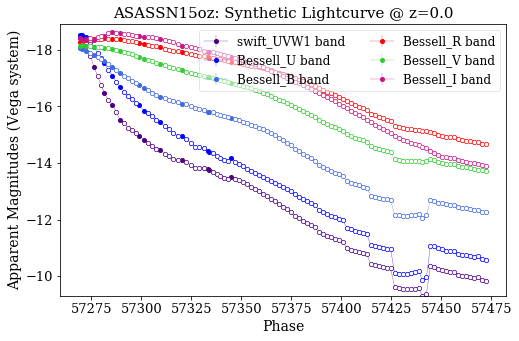

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
112 112 112
112 112 112
112 112 112
112 112 112
112 112 112
112 112 112
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


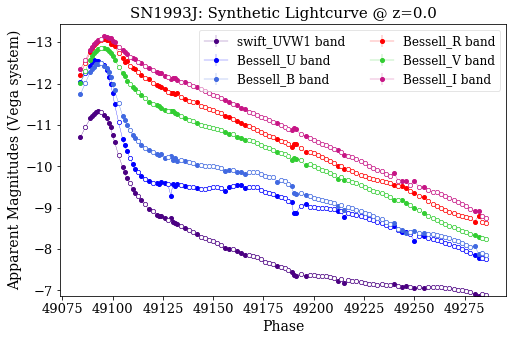

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
110 110 110
110 110 110
110 110 110
110 110 110
110 110 110
110 110 110
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


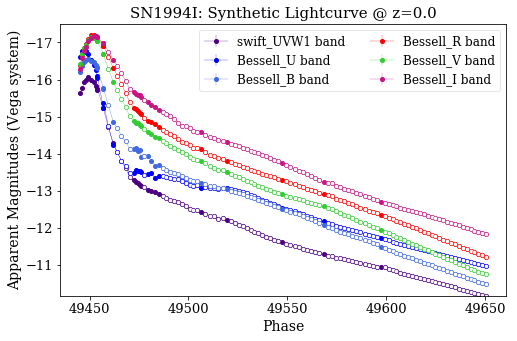

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
74 74 74
74 74 74
74 74 74
74 74 74
74 74 74
74 74 74
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


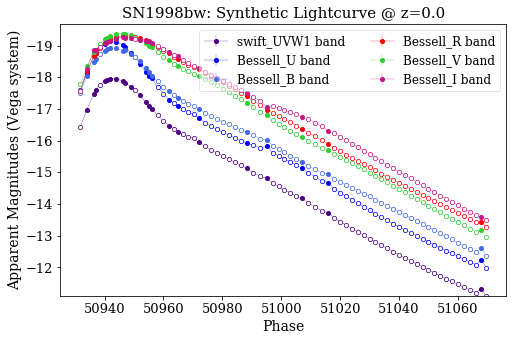

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
107 107 107
107 107 107
107 107 107
107 107 107
107 107 107
107 107 107
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


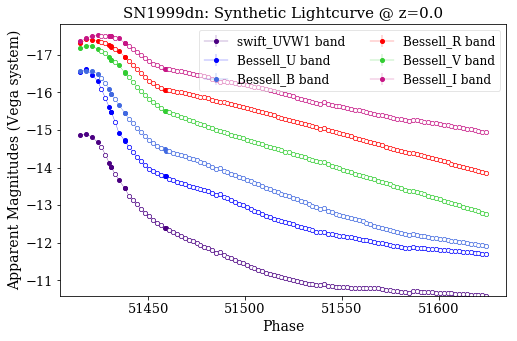

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
106 106 106
106 106 106
106 106 106
106 106 106
106 106 106
106 106 106
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


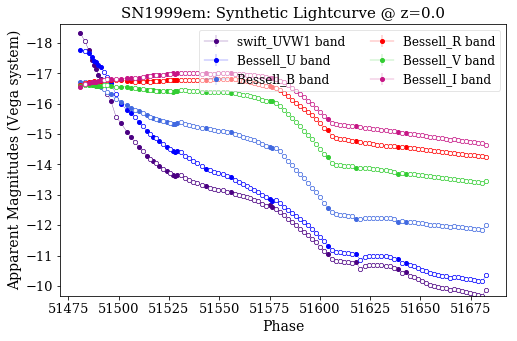

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
109 109 109
109 109 109
109 109 109
109 109 109
109 109 109
109 109 109
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


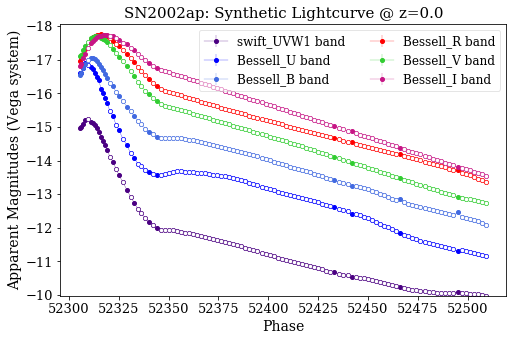

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
112 112 112
112 112 112
112 112 112
112 112 112
112 112 112
112 112 112
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


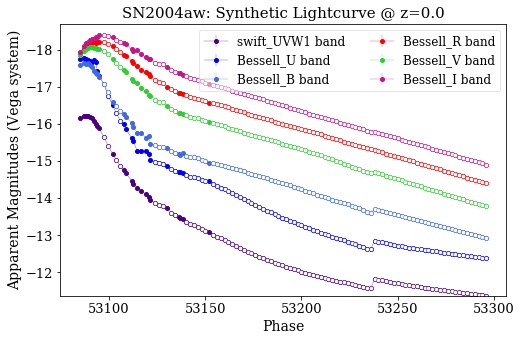

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
106 106 106
106 106 106
106 106 106
106 106 106
106 106 106
106 106 106
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


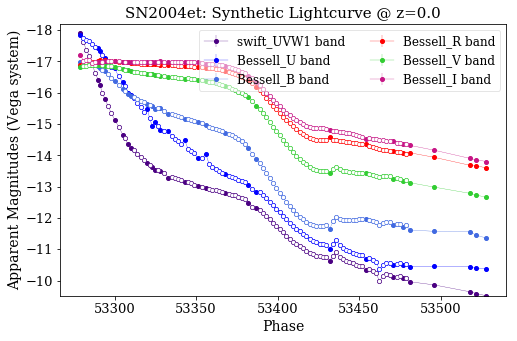

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
78 78 78
78 78 78
78 78 78
78 78 78
78 78 78
78 78 78
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


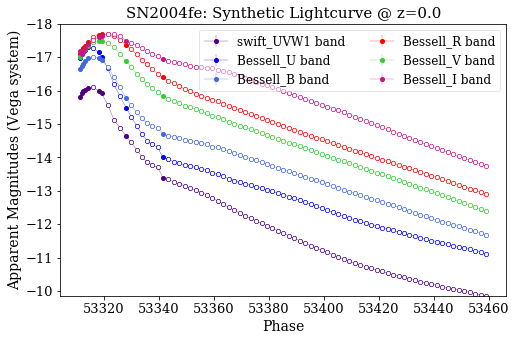

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
89 89 89
89 89 89
89 89 89
89 89 89
89 89 89
89 89 89
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


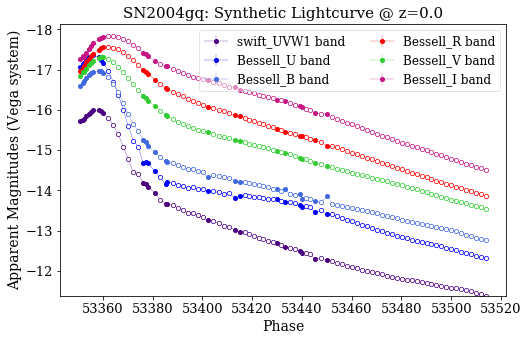

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
100 100 100
100 100 100
100 100 100
100 100 100
100 100 100
100 100 100
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


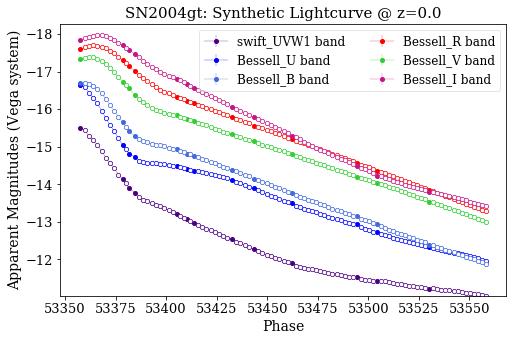

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
70 70 70
70 70 70
70 70 70
70 70 70
70 70 70
70 70 70
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


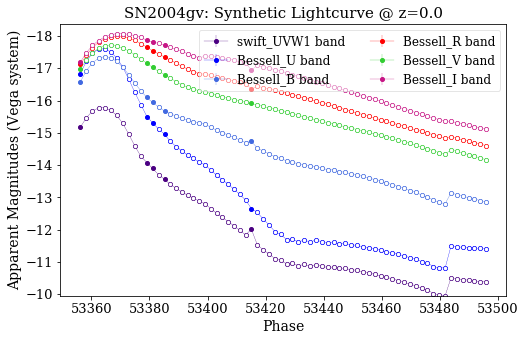

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
107 107 107
107 107 107
107 107 107
107 107 107
107 107 107
107 107 107
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


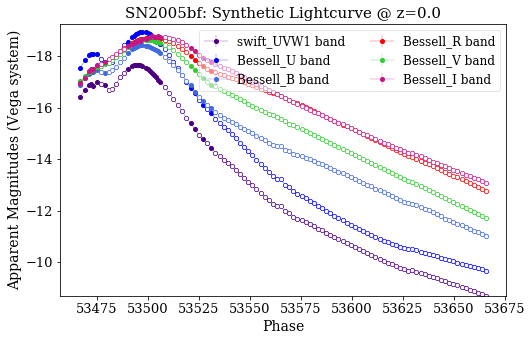

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
106 106 106
106 106 106
106 106 106
106 106 106
106 106 106
106 106 106
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


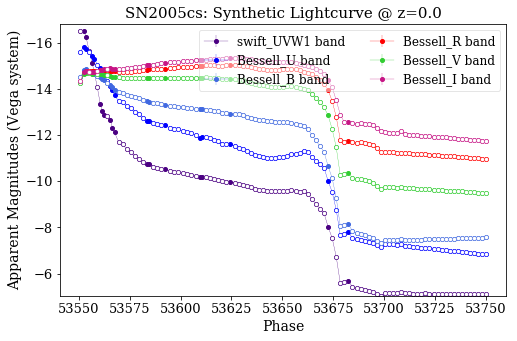

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
115 115 115
115 115 115
115 115 115
115 115 115
115 115 115
115 115 115
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


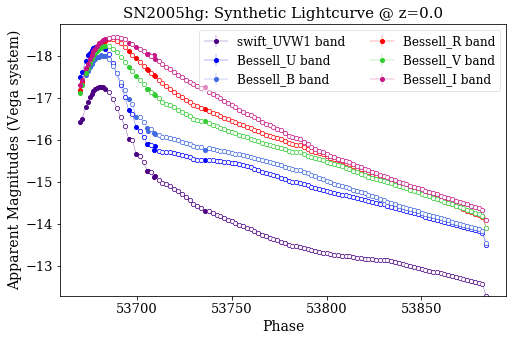

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
101 101 101
101 101 101
101 101 101
101 101 101
101 101 101
101 101 101
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


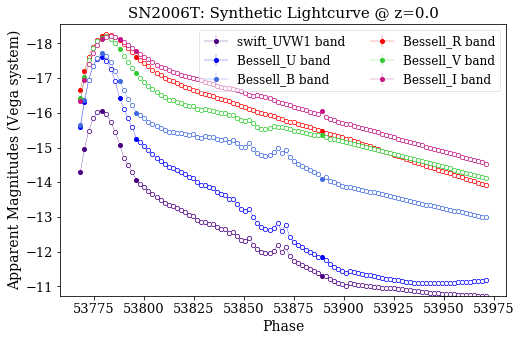

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
101 101 101
101 101 101
101 101 101
101 101 101
101 101 101
101 101 101
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


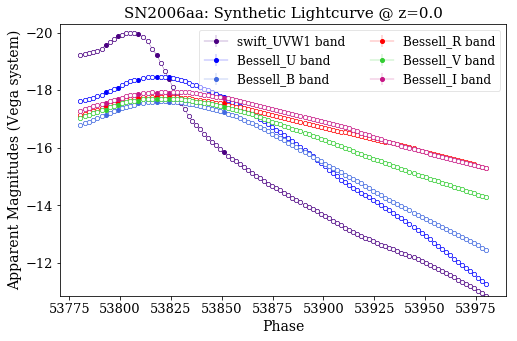

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
32 32 32
32 32 32
32 32 32
32 32 32
32 32 32
32 32 32
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


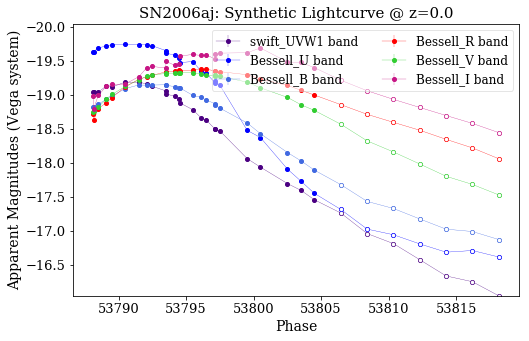

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
99 99 99
99 99 99
99 99 99
99 99 99
99 99 99
99 99 99
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


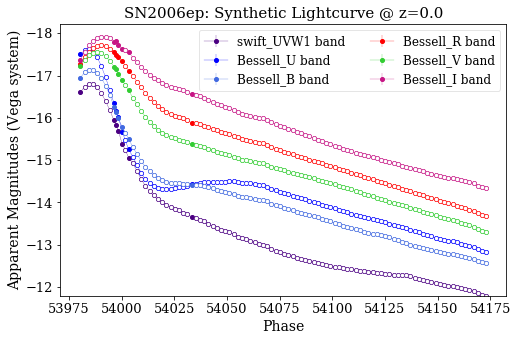

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
75 75 75
75 75 75
75 75 75
75 75 75
75 75 75
75 75 75
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


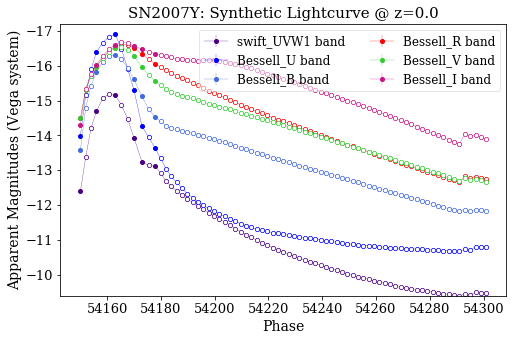

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
118 118 118
118 118 118
118 118 118
118 118 118
118 118 118
118 118 118
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


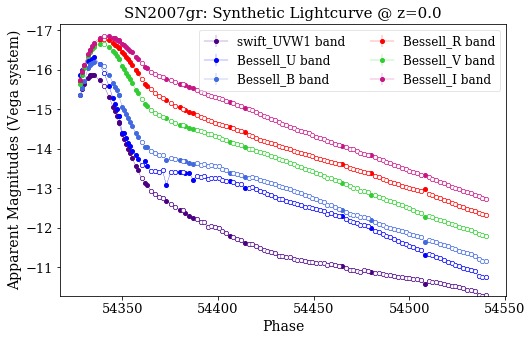

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
104 104 104
104 104 104
104 104 104
104 104 104
104 104 104
104 104 104
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


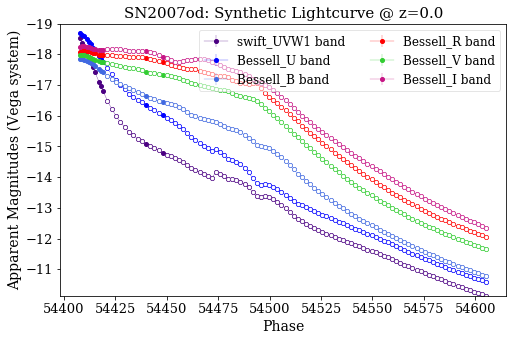

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
89 89 89
89 89 89
89 89 89
89 89 89
89 89 89
89 89 89
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


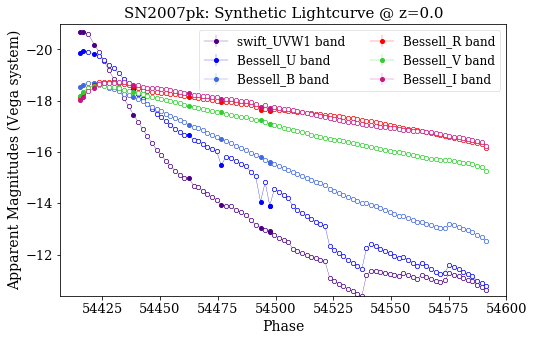

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
102 102 102
102 102 102
102 102 102
102 102 102
102 102 102
102 102 102
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


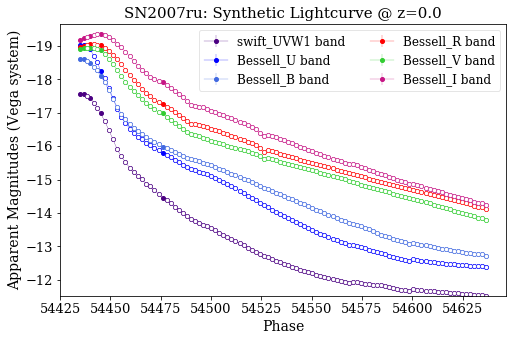

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
102 102 102
102 102 102
102 102 102
102 102 102
102 102 102
102 102 102
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


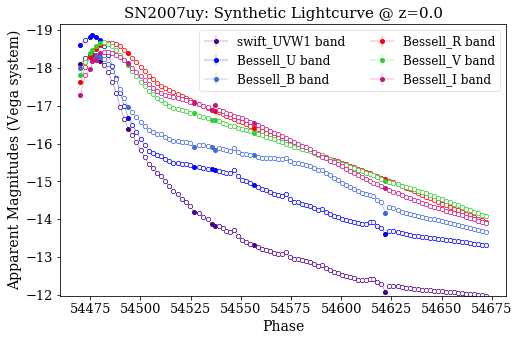

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
117 117 117
117 117 117
117 117 117
117 117 117
117 117 117
117 117 117
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


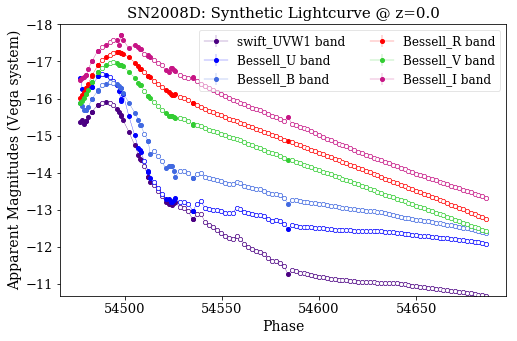

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
53 53 53
53 53 53
53 53 53
53 53 53
53 53 53
53 53 53
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


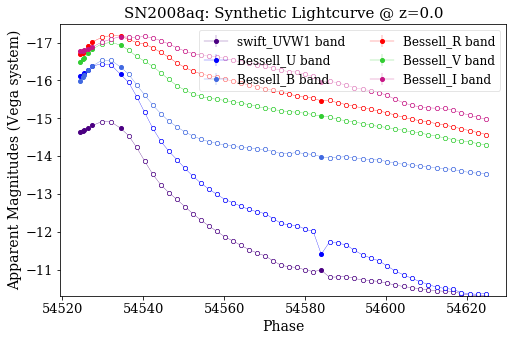

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
132 132 132
132 132 132
132 132 132
132 132 132
132 132 132
132 132 132
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


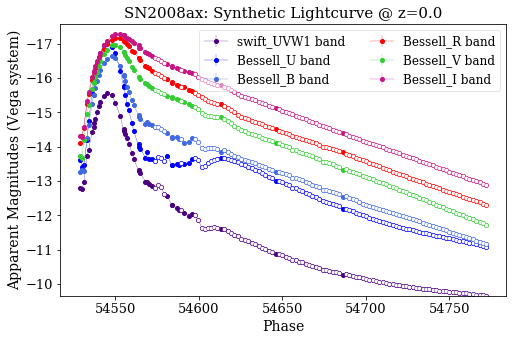

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
105 105 105
105 105 105
105 105 105
105 105 105
105 105 105
105 105 105
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


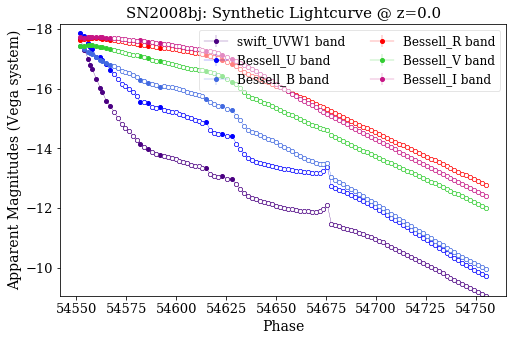

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
103 103 103
103 103 103
103 103 103
103 103 103
103 103 103
103 103 103
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


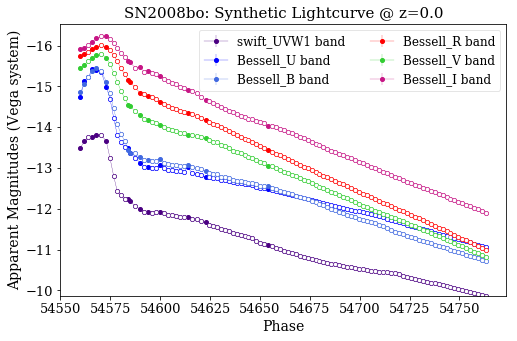

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
85 85 85
85 85 85
85 85 85
85 85 85
85 85 85
85 85 85
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


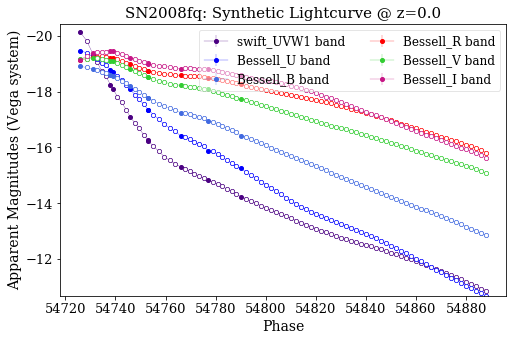

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
87 87 87
87 87 87
87 87 87
87 87 87
87 87 87
87 87 87
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


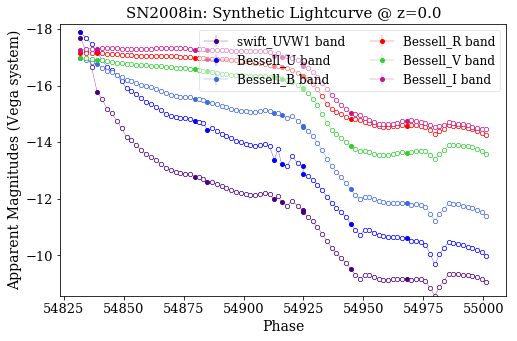

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
72 72 72
72 72 72
72 72 72
72 72 72
72 72 72
72 72 72
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


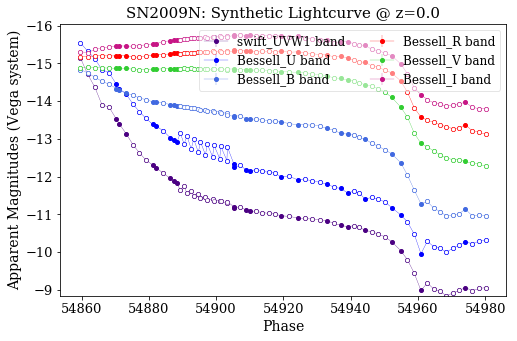

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
81 81 81
81 81 81
81 81 81
81 81 81
81 81 81
81 81 81
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


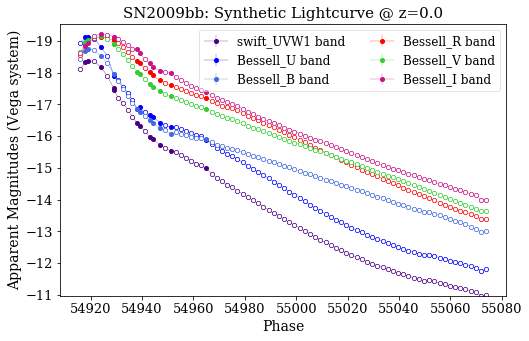

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
102 102 102
102 102 102
102 102 102
102 102 102
102 102 102
102 102 102
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


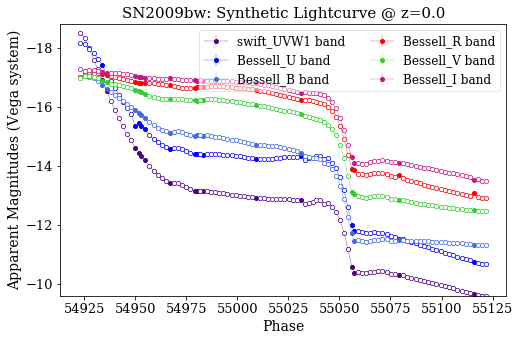

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
104 104 104
104 104 104
104 104 104
104 104 104
104 104 104
104 104 104
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


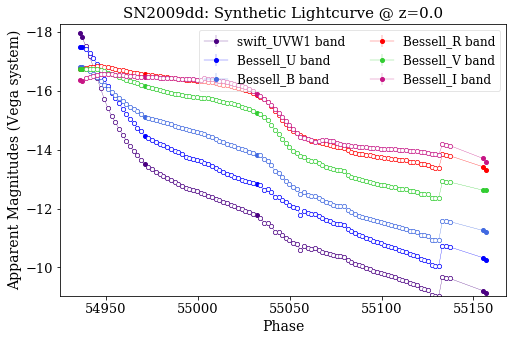

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
104 104 104
104 104 104
104 104 104
104 104 104
104 104 104
104 104 104
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


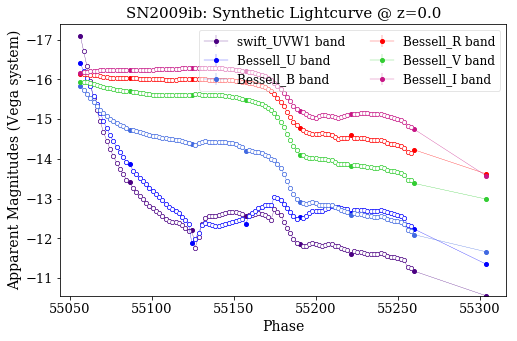

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
126 126 126
126 126 126
126 126 126
126 126 126
126 126 126
126 126 126
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


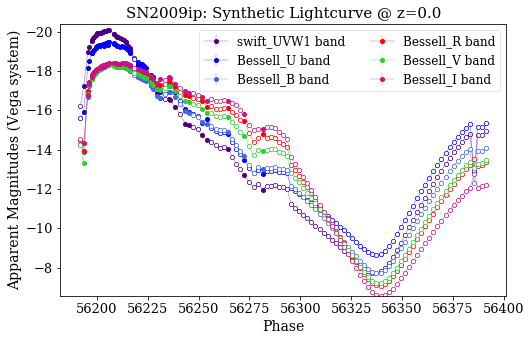

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
103 103 103
103 103 103
103 103 103
103 103 103
103 103 103
103 103 103
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


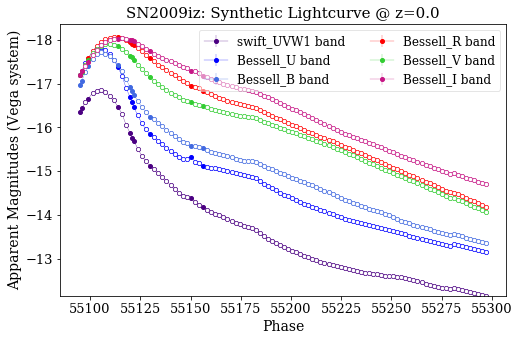

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
106 106 106
106 106 106
106 106 106
106 106 106
106 106 106
106 106 106
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


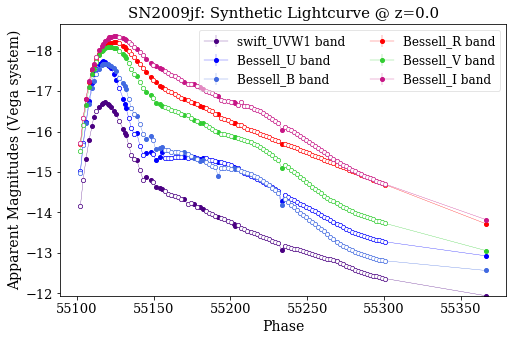

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
54 54 54
54 54 54
54 54 54
54 54 54
54 54 54
54 54 54
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


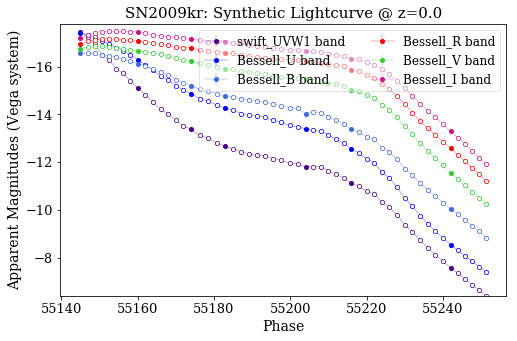

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
67 67 67
67 67 67
67 67 67
67 67 67
67 67 67
67 67 67
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


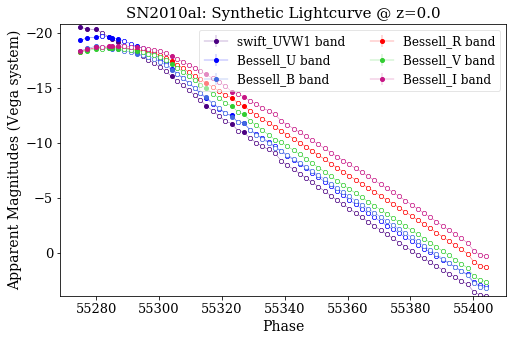

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
102 102 102
102 102 102
102 102 102
102 102 102
102 102 102
102 102 102
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


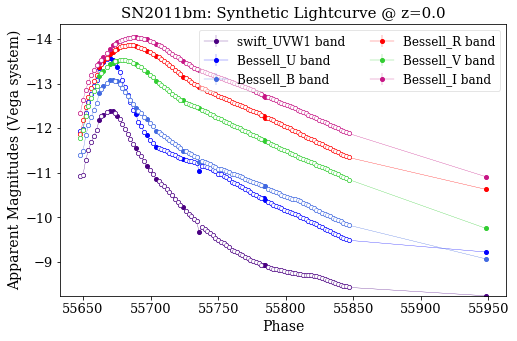

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
104 104 104
104 104 104
104 104 104
104 104 104
104 104 104
104 104 104
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


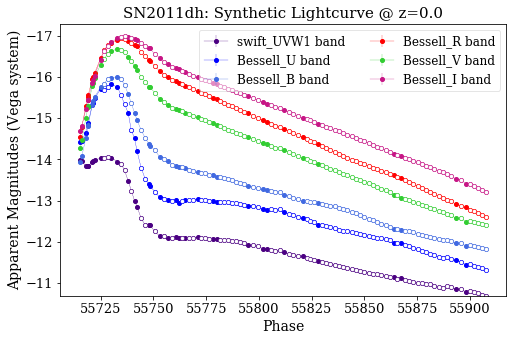

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
73 73 73
73 73 73
73 73 73
73 73 73
73 73 73
73 73 73
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


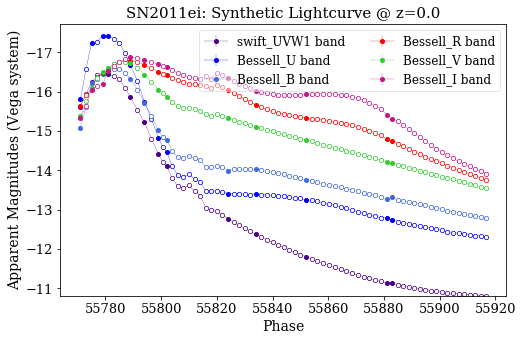

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
108 108 108
108 108 108
108 108 108
108 108 108
108 108 108
108 108 108
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


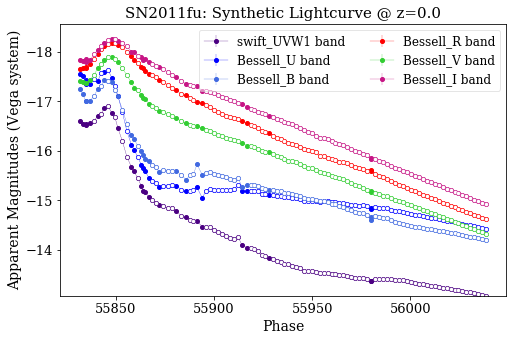

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
104 104 104
104 104 104
104 104 104
104 104 104
104 104 104
104 104 104
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


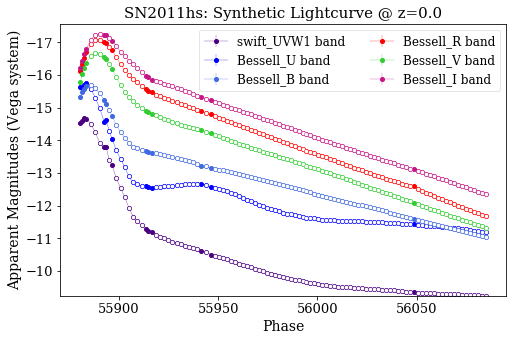

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
102 102 102
102 102 102
102 102 102
102 102 102
102 102 102
102 102 102
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/astropy/units/quantity.py:641: RuntimeWarning: invalid value encountered in log10
  *arrays, **kwargs)


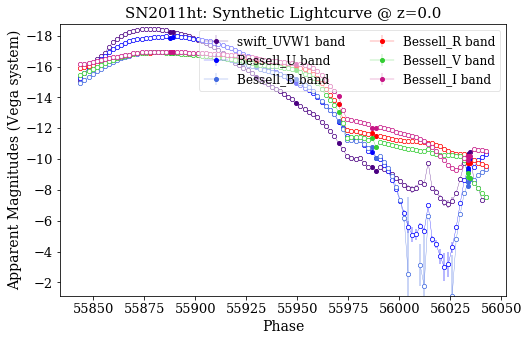

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
106 106 106
106 106 106
106 106 106
106 106 106
106 106 106
106 106 106
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


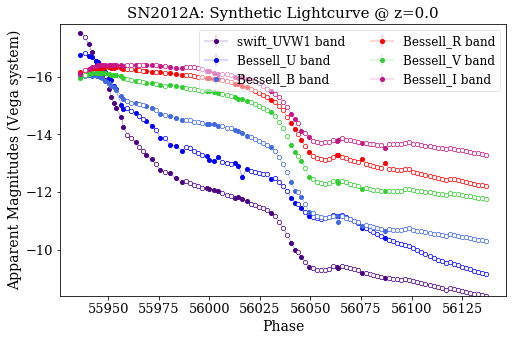

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
67 67 67
67 67 67
67 67 67
67 67 67
67 67 67
67 67 67
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


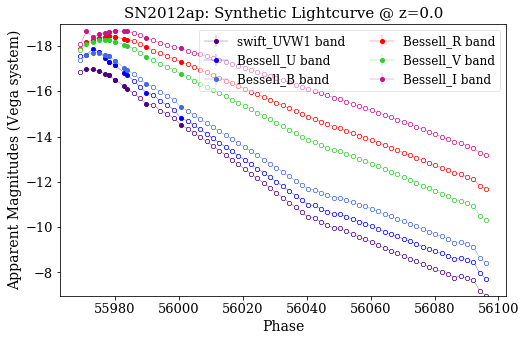

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
103 103 103
103 103 103
103 103 103
103 103 103
103 103 103
103 103 103
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


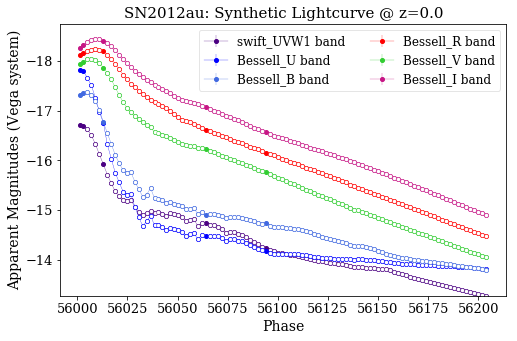

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
121 121 121
121 121 121
121 121 121
121 121 121
121 121 121
121 121 121
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


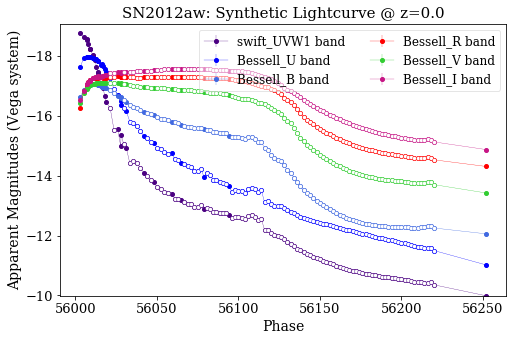

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
102 102 102
102 102 102
102 102 102
102 102 102
102 102 102
102 102 102
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


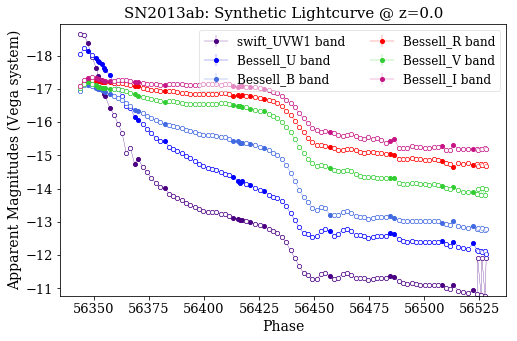

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
105 105 105
105 105 105
105 105 105
105 105 105
105 105 105
105 105 105
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


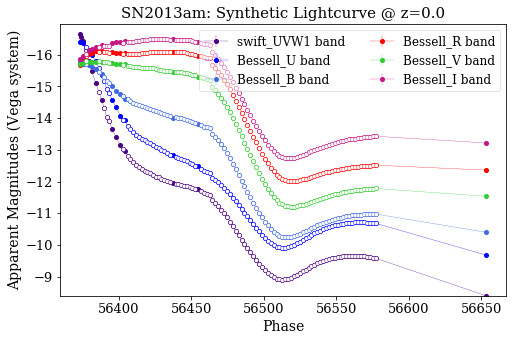

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
103 103 103
103 103 103
103 103 103
103 103 103
103 103 103
103 103 103
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


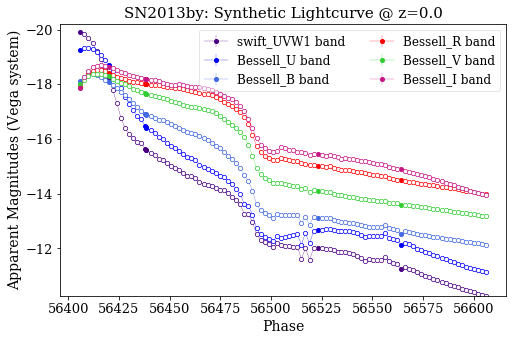

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
104 104 104
104 104 104
104 104 104
104 104 104
104 104 104
104 104 104
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


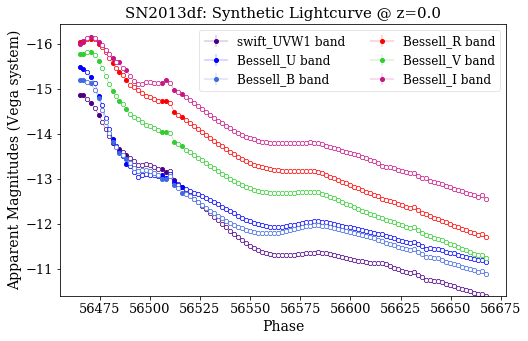

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
105 105 105
105 105 105
105 105 105
105 105 105
105 105 105
105 105 105
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


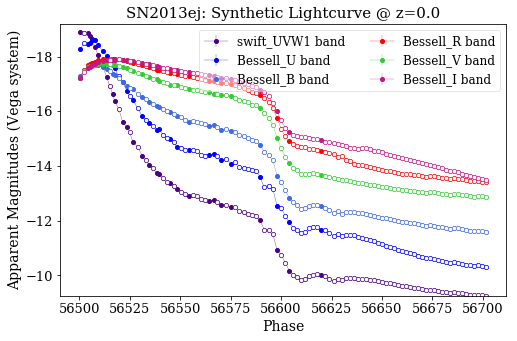

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
60 60 60
60 60 60
60 60 60
60 60 60
60 60 60
60 60 60
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


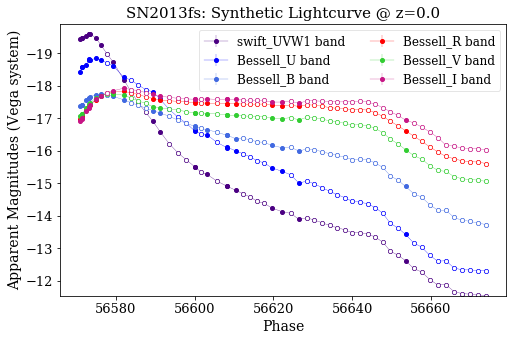

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
84 84 84
84 84 84
84 84 84
84 84 84
84 84 84
84 84 84
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


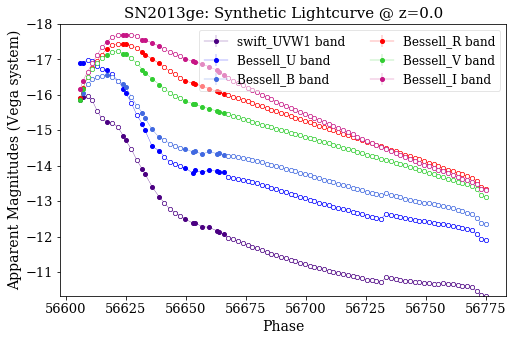

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
103 103 103
103 103 103
103 103 103
103 103 103
103 103 103
103 103 103
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


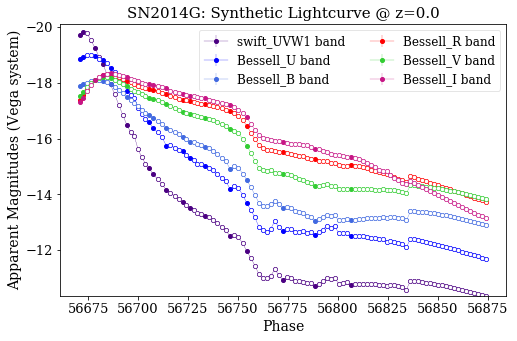

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
111 111 111
111 111 111
111 111 111
111 111 111
111 111 111
111 111 111
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


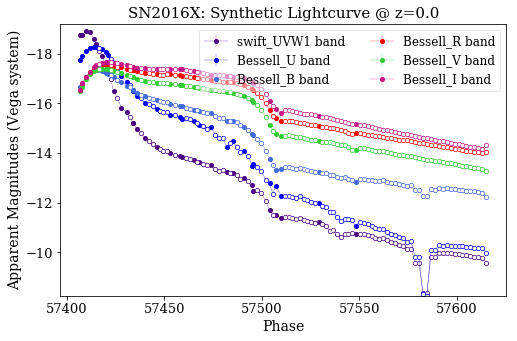

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
106 106 106
106 106 106
106 106 106
106 106 106
106 106 106
106 106 106
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


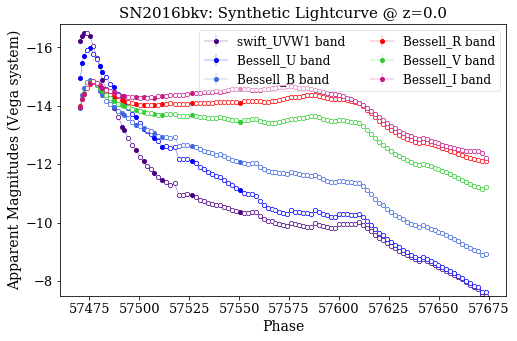

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
106 106 106
106 106 106
106 106 106
106 106 106
106 106 106
106 106 106
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


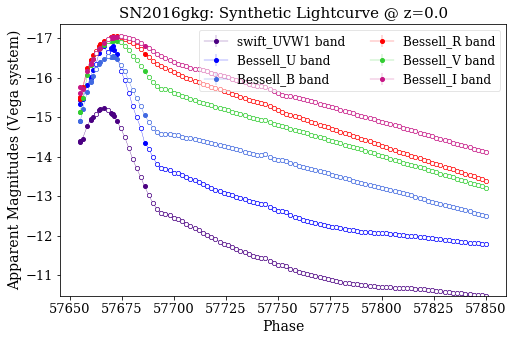

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
113 113 113
113 113 113
113 113 113
113 113 113
113 113 113
113 113 113
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


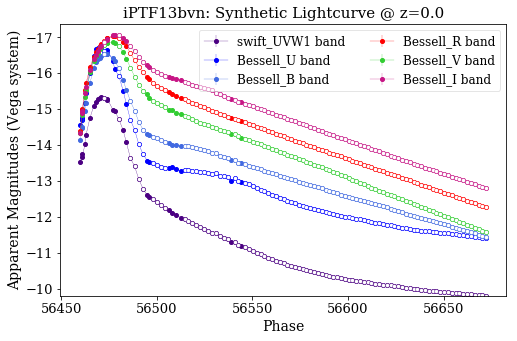

Computing GP fit (for the first time)
Interpolating with GPs  swift_UVW1 final True
103 103 103
103 103 103
103 103 103
103 103 103
103 103 103
103 103 103
Interpolating with GPs  Bessell_U final True
Interpolating with GPs  Bessell_B final True
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


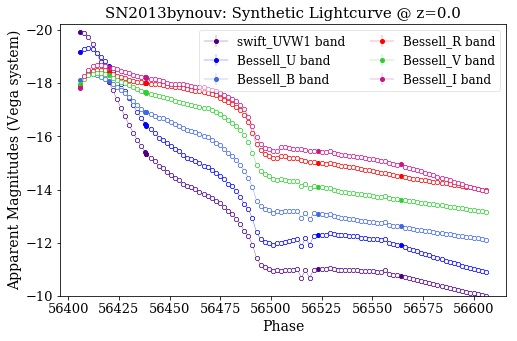

In [11]:
for snname,typ in sn_type_lista:
    FL_mode=True
    LC = FinalLC(main_path=DATALC_PATH, snname=snname, twodim=True)
    dicts_LC_gp = LC.LCfit_withGP(0.0, f_list=['swift_UVW1', 'Bessell_U','Bessell_B', 'Bessell_R', 'Bessell_V', 'Bessell_I'], final=True)
    LC.save_plot_GPfit(f_list=['swift_UVW1','Bessell_U','Bessell_B', 'Bessell_R', 'Bessell_V', 'Bessell_I'])
    

In [17]:
FL_mode=True
snname ='iPTF13bvn'
LC = FinalLC(main_path=DATALC_PATH, snname=snname, twodim=True)

In [18]:
len(LC.get_spec_list(final=True))

113

In [19]:
len(LC.get_spec_list(final=False))

113

In [20]:
DATA = LC.load_original_phot()

In [21]:
LC.get_avail_filt()

['Bessell_B',
 'Bessell_I',
 'Bessell_R',
 'Bessell_U',
 'Bessell_V',
 "sdss_g'",
 "sdss_i'",
 "sdss_r'",
 "sdss_z'",
 'swift_B',
 'swift_U',
 'swift_UVW1',
 'swift_UVW2',
 'swift_V']

In [22]:
#dicts_LC = LC.get_remangled_photometry(0.0, ['swift_UVW1'])

In [23]:
dicts_LC = LC.get_remangled_photometry(0.0, LC.get_avail_filt())

113 113 113
113 113 113
113 113 113
113 113 113
113 113 113
113 113 113
113 113 113
113 113 113
113 113 113
113 113 113
113 113 113
113 113 113
113 113 113
113 113 113


In [24]:
dicts_LC.keys()

dict_keys(['swift_B', 'Bessell_B', 'Bessell_V', 'swift_U', "sdss_g'", 'swift_UVW2', 'Bessell_R', "sdss_z'", "sdss_r'", 'swift_UVW1', "sdss_i'", 'Bessell_U', 'swift_V', 'Bessell_I'])

In [25]:
#dicts_LC_gp = LC.LCfit_withGP(0.0, f_list=['swift_UVW2', 'sdss_g', 'swift_U', 'swift_UVW1'])
#dicts_LC_gp = LC.LCfit_withGP(0.0, f_list=['swift_UVW2', 'sdss_g', 'swift_U', 'swift_UVW1'])

In [26]:
#dicts_LC_gp = LC.LCfit_withGP(0.0, f_list=all_filters)

In [27]:
#dicts_LC_gp.keys()

In [28]:
#fig = plt.figure(1, figsize=(13,9))
#for band in all_filters:
#    plt.errorbar(dicts_LC[band]['time'], dicts_LC[band]['flux'], yerr=dicts_LC[band]['flux_err'], 
#                 color = color_dict[band], ecolor = color_dict[band], marker='.',label=band)
#plt.xlim(min(LC.get_spec_mjd())-5, max(LC.get_spec_mjd())+30)
#plt.legend(fontsize=15)
#plt.title(LC.snname)
#plt.grid()

In [29]:
LC.create_results_folder()

In [30]:
dicts_LC_gp = LC.LCfit_withGP(0.0, f_list=LC.avail_filters)

Computing GP fit (for the first time)
Interpolating with GPs  Bessell_B final False
Interpolating with GPs  Bessell_I final False
Interpolating with GPs  Bessell_R final False
Interpolating with GPs  Bessell_U final False
Interpolating with GPs  Bessell_V final False
Interpolating with GPs  sdss_g' final False
Interpolating with GPs  sdss_i' final False
Interpolating with GPs  sdss_r' final False
Interpolating with GPs  sdss_z' final False
Interpolating with GPs  swift_B final False
Interpolating with GPs  swift_U final False
Interpolating with GPs  swift_UVW1 final False
Interpolating with GPs  swift_UVW2 final False
Interpolating with GPs  swift_V final False


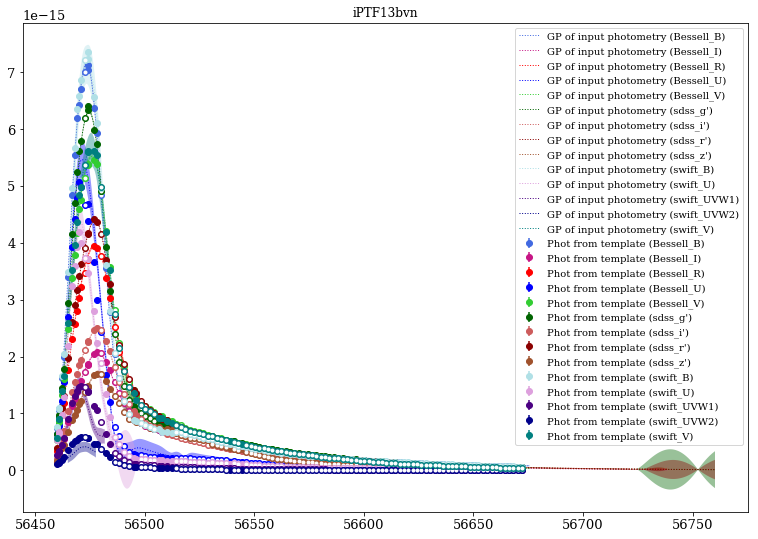

In [31]:
fig = plt.figure(1, figsize=(13,9))

mask_fake = [t in LC.get_spec_mjd_fake() for t in dicts_LC[LC.avail_filters[0]]['time']]

for band in LC.avail_filters:
    plt.errorbar(dicts_LC[band]['time'], dicts_LC[band]['flux'], yerr=dicts_LC[band]['flux_err'],
                 color= color_dict[band], ecolor= color_dict[band],\
             marker='o', label='Phot from template (%s)'%band, linestyle='None')
    
    plt.errorbar(np.array(dicts_LC[band]['time'])[mask_fake], np.array(dicts_LC[band]['flux'])[mask_fake], 
             yerr=np.array(dicts_LC[band]['flux_err'])[mask_fake],
            color= 'white', ecolor= color_dict[band], marker='.', linestyle='None')

    #= DATA['filter']==band
    plt.plot(DATA['MJD'], DATA[band], color=color_dict[band],
                linestyle=':', marker='None', lw=1., label='GP of input photometry (%s)'%band)
    plt.fill_between(DATA['MJD'], DATA[band]-DATA[band+'_err'], DATA[band]+DATA[band+'_err'],
                     facecolor=color_dict[band], alpha=0.4)

#plt.xlim(min(LC.get_spec_mjd())-5, max(LC.get_spec_mjd())+30)
#plt.vlines(LC.get_spec_mjd(), 0, max([max(dicts_LC[b]['flux']) for b in LC.avail_filters]), lw=0.3, label='Spectra')
#plt.vlines(LC.get_spec_mjd_fake(), 0, max([max(dicts_LC[b]['flux']) for b in LC.avail_filters]), 
#           lw=.6, color='r', linestyle=':', label='Artificial spectra')
plt.legend(loc='upper right')
plt.title(LC.snname)
if FL_mode:
    fig.savefig(LC.results_mainpath+'Final_SpecTempl_cfr_FL.pdf', bbox_inches='tight')
else:
    fig.savefig(LC.results_mainpath+'Final_SpecTempl_cfr.pdf', bbox_inches='tight')

plt.show()
plt.close(fig)

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/scale.py:114: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


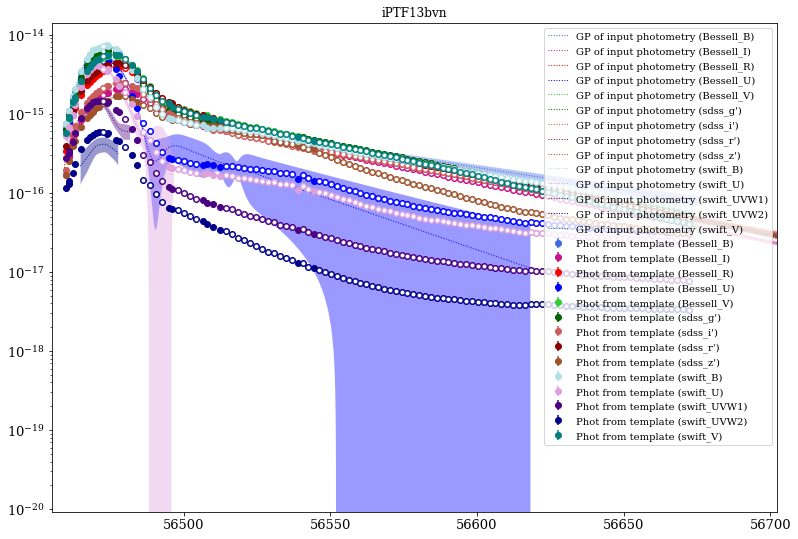

In [32]:
fig = plt.figure(1, figsize=(13,9))

mask_fake = [t in LC.get_spec_mjd_fake() for t in dicts_LC[band]['time']]

for band in LC.avail_filters:
    plt.errorbar(dicts_LC[band]['time'], dicts_LC[band]['flux'], yerr=dicts_LC[band]['flux_err'],
                 color= color_dict[band], ecolor= color_dict[band],\
             marker='o', label='Phot from template (%s)'%band, linestyle='None')
    
    plt.errorbar(np.array(dicts_LC[band]['time'])[mask_fake], np.array(dicts_LC[band]['flux'])[mask_fake], 
             yerr=np.array(dicts_LC[band]['flux_err'])[mask_fake],
            color= 'white', ecolor= color_dict[band], marker='.', linestyle='None')
    plt.plot(DATA['MJD'], DATA[band], color=color_dict[band],
                linestyle=':', marker='None', lw=1., label='GP of input photometry (%s)'%band)
    plt.fill_between(DATA['MJD'], DATA[band]-DATA[band+'_err'], DATA[band]+DATA[band+'_err'],
                     facecolor=color_dict[band], alpha=0.4)

plt.xlim(min(LC.get_spec_mjd())-5, max(LC.get_spec_mjd())+30)
plt.legend(loc='upper right')
#plt.vlines(LC.get_spec_mjd(), 0, max([max(dicts_LC[b]['flux']) for b in LC.avail_filters]), lw=0.3)
#plt.vlines(LC.get_spec_mjd_fake(), 0, max([max(dicts_LC[b]['flux']) for b in LC.avail_filters]), 
#           lw=.05, color='r', linestyle=':')
plt.ylim()
plt.title(LC.snname)
plt.yscale('log')
if FL_mode:
    fig.savefig(LC.results_mainpath+'Final_SpecTempl_cfr_LOG_FL.pdf', bbox_inches='tight')
else:
    fig.savefig(LC.results_mainpath+'Final_SpecTempl_cfr_LOG.pdf', bbox_inches='tight')
plt.show()
plt.close(fig)

In [33]:
LC.results_mainpath

'/Users/mariavincenzi/PhD/pycoco_2/data//results_template/iPTF13bvn/'

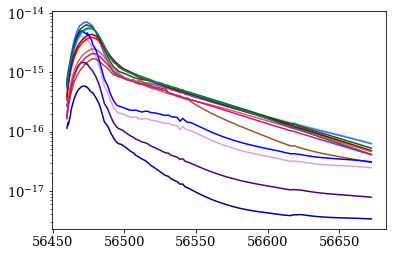

In [34]:
## write file for GIF
## write file for GIF
## write file for GIF

fout = open(LC.results_mainpath+'LC_refitted_FL.csv', 'w')
fout.write('time,flux,band\n')
for band in dicts_LC_gp.keys():
    plt.errorbar(dicts_LC_gp[band]['time'], dicts_LC_gp[band]['flux'], 
                 color = color_dict[band])
    for t,f in zip(dicts_LC_gp[band]['time'], dicts_LC_gp[band]['flux']):
        fout.write('%.2f,%.2E,%s\n'%(t,f,band))
fout.close()
plt.yscale('log')
## write file for GIF
## write file for GIF
## write file for GIF

Computing GP fit (for the first time)
Interpolating with GPs  Bessell_B final True
113 113 113
113 113 113
113 113 113
113 113 113
Interpolating with GPs  Bessell_R final True
Interpolating with GPs  Bessell_V final True
Interpolating with GPs  Bessell_I final True


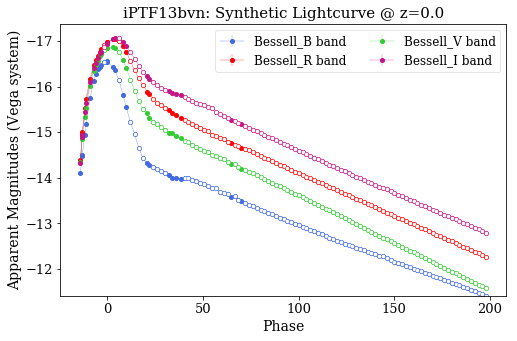

In [35]:
LC = FinalLC(main_path=DATALC_PATH, snname=snname, twodim=True)
dicts_LC_gp = LC.LCfit_withGP(0.0, f_list=['Bessell_B', 'Bessell_R', 'Bessell_V', 'Bessell_I'], final=True)
LC.save_plot_GPfit(f_list=['Bessell_B', 'Bessell_R', 'Bessell_V', 'Bessell_I'])

In [36]:
lsst_filters = ['LSST_LSSTu', 'LSST_LSSTg', 'LSST_LSSTr', 'LSST_LSSTi']

Computing GP fit (for the first time)
Interpolating with GPs  LSST_LSSTu final True
113 113 113
113 113 113
113 113 113
113 113 113
Interpolating with GPs  LSST_LSSTg final True
Interpolating with GPs  LSST_LSSTr final True
Interpolating with GPs  LSST_LSSTi final True


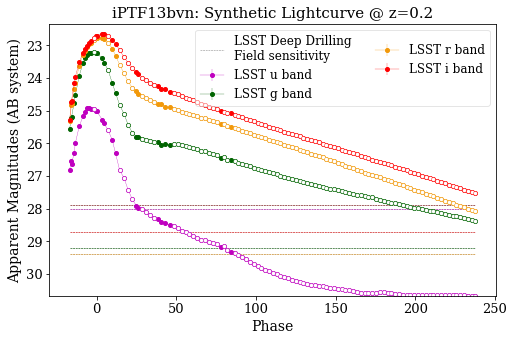

In [37]:
LC = FinalLC(main_path=DATALC_PATH, snname=snname, twodim=True)
dicts_LC_gp = LC.LCfit_withGP(0.2, f_list=lsst_filters, final=True)
LC.save_plot_GPfit(f_list=lsst_filters)

Computing GP fit (for the first time)
Interpolating with GPs  LSST_LSSTu final True
113 113 113
113 113 113
113 113 113
113 113 113
Interpolating with GPs  LSST_LSSTg final True
Interpolating with GPs  LSST_LSSTr final True
Interpolating with GPs  LSST_LSSTi final True


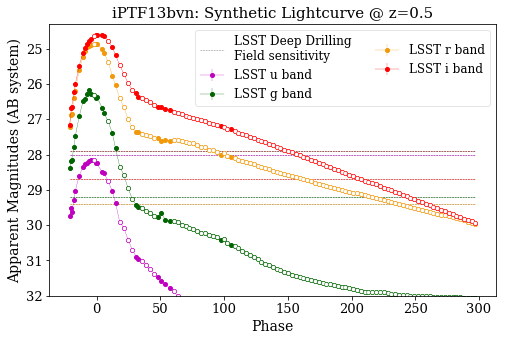

In [38]:
LC = FinalLC(main_path=DATALC_PATH, snname=snname, twodim=True)
dicts_LC_gp = LC.LCfit_withGP(0.5, f_list=lsst_filters, final=True)
LC.save_plot_GPfit(f_list=lsst_filters)

Computing GP fit (for the first time)
Interpolating with GPs  LSST_LSSTu final True
113 113 113
113 113 113
113 113 113
113 113 113
Interpolating with GPs  LSST_LSSTg final True
Interpolating with GPs  LSST_LSSTr final True
Interpolating with GPs  LSST_LSSTi final True


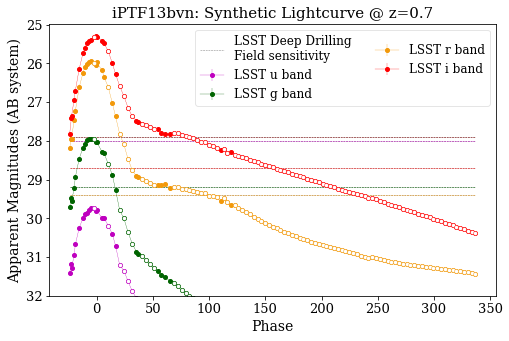

In [39]:
LC = FinalLC(main_path=DATALC_PATH, snname=snname, twodim=True)
dicts_LC_gp = LC.LCfit_withGP(0.7, f_list=lsst_filters, final=True)
LC.save_plot_GPfit(f_list=lsst_filters)

Computing GP fit (for the first time)
Interpolating with GPs  DES_g final True
102 102 102
102 102 102
102 102 102
102 102 102
Interpolating with GPs  DES_r final True
Interpolating with GPs  DES_i final True
Interpolating with GPs  DES_z final True


Text(0.5,1,'SN2011ht')

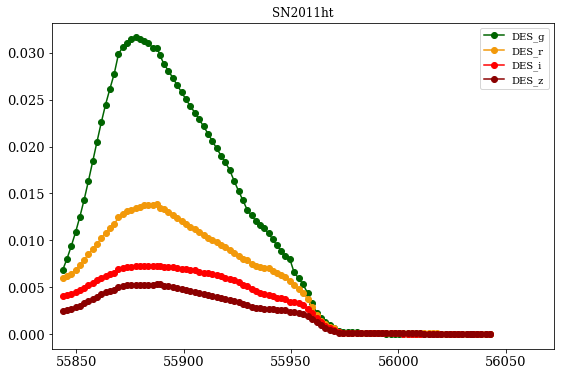

In [54]:
LC = FinalLC(main_path=DATALC_PATH, snname=snname, twodim=True)
dicts_LC_gp = LC.LCfit_withGP(0., f_list=des_filters, final=True)

fig = plt.figure(1, figsize=(9,6))

for band in ['DES_g', 'DES_r', 'DES_i', 'DES_z']:
    plt.plot(dicts_LC_gp[band]['time'], (dicts_LC_gp[band]['flux']), color= color_dict[band], label=band,
            marker='o')
plt.xlim(min(LC.get_spec_mjd())-5, max(LC.get_spec_mjd())+30)
plt.legend()
plt.title(LC.snname)

Forcing to do GP fit again
Interpolating with GPs  DES_g final True
102 102 102
102 102 102
102 102 102
102 102 102
Interpolating with GPs  DES_r final True
Interpolating with GPs  DES_i final True
Interpolating with GPs  DES_z final True


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/astropy/units/quantity.py:641: RuntimeWarning: invalid value encountered in log10
  *arrays, **kwargs)


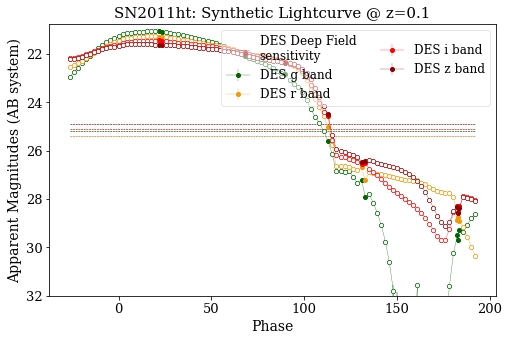

In [55]:
dicts_LC_gp = LC.LCfit_withGP(0.1, f_list=des_filters, final=True)
LC.save_plot_GPfit(f_list=des_filters)

Forcing to do GP fit again
Interpolating with GPs  DES_g final True
102 102 102
102 102 102
102 102 102
102 102 102
Interpolating with GPs  DES_r final True
Interpolating with GPs  DES_i final True
Interpolating with GPs  DES_z final True


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/astropy/units/quantity.py:641: RuntimeWarning: invalid value encountered in log10
  *arrays, **kwargs)


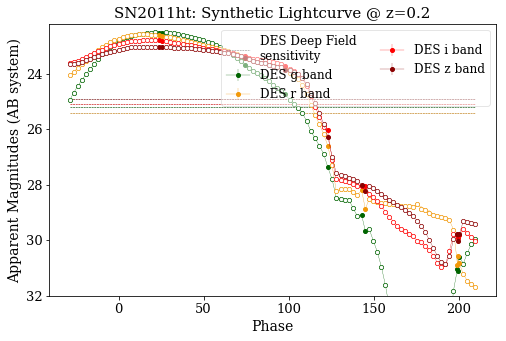

In [56]:
dicts_LC_gp = LC.LCfit_withGP(0.2, f_list=des_filters, final=True)
LC.save_plot_GPfit(f_list=des_filters)

Forcing to do GP fit again
Interpolating with GPs  DES_g final True
102 102 102
102 102 102
102 102 102
102 102 102
Interpolating with GPs  DES_r final True
Interpolating with GPs  DES_i final True
Interpolating with GPs  DES_z final True


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/astropy/units/quantity.py:641: RuntimeWarning: invalid value encountered in log10
  *arrays, **kwargs)


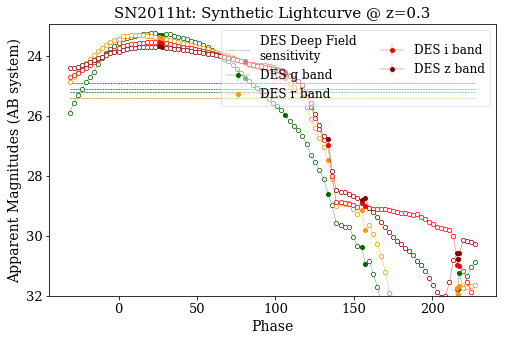

In [57]:
dicts_LC_gp = LC.LCfit_withGP(0.3, f_list=des_filters, final=True)
LC.save_plot_GPfit(f_list=des_filters)

Forcing to do GP fit again
Interpolating with GPs  DES_g final True
102 102 102
102 102 102
102 102 102
102 102 102
Interpolating with GPs  DES_r final True
Interpolating with GPs  DES_i final True
Interpolating with GPs  DES_z final True


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/astropy/units/quantity.py:641: RuntimeWarning: invalid value encountered in log10
  *arrays, **kwargs)


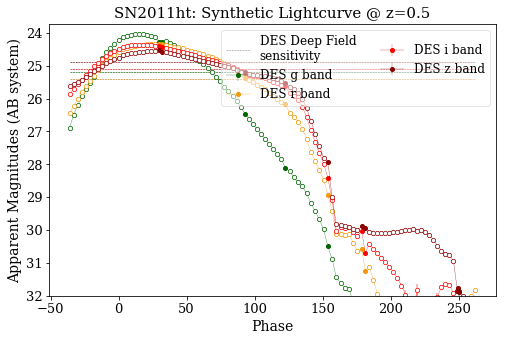

In [58]:
dicts_LC_gp = LC.LCfit_withGP(0.5, f_list=des_filters, final=True)
LC.save_plot_GPfit(f_list=des_filters)

Forcing to do GP fit again
Interpolating with GPs  DES_g final True
102 102 102
102 102 102
102 102 102
102 102 102
Interpolating with GPs  DES_r final True
Interpolating with GPs  DES_i final True
Interpolating with GPs  DES_z final True


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/astropy/units/quantity.py:641: RuntimeWarning: invalid value encountered in log10
  *arrays, **kwargs)


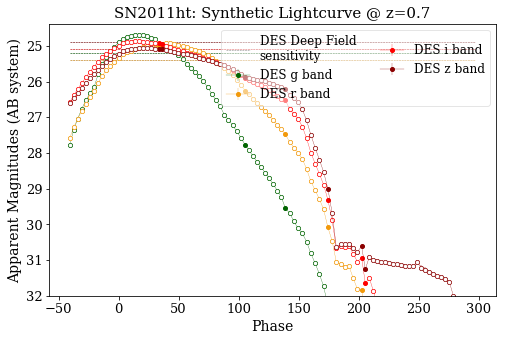

In [59]:
dicts_LC_gp = LC.LCfit_withGP(0.7, f_list=des_filters, final=True)
LC.save_plot_GPfit(f_list=des_filters)

Forcing to do GP fit again
Interpolating with GPs  DES_g final True
102 102 102
102 102 102
102 102 102
102 102 102
Interpolating with GPs  DES_r final True
Interpolating with GPs  DES_i final True
Interpolating with GPs  DES_z final True


/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/astropy/units/quantity.py:641: RuntimeWarning: invalid value encountered in log10
  *arrays, **kwargs)
/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/astropy/units/quantity.py:641: RuntimeWarning: invalid value encountered in less
  *arrays, **kwargs)


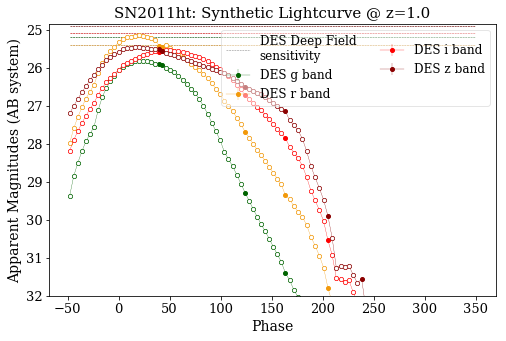

In [60]:
dicts_LC_gp = LC.LCfit_withGP(1, f_list=des_filters, final=True)
LC.save_plot_GPfit(f_list=des_filters)

In [ ]:
#   snfactory_path = '/Users/mariavincenzi/PhD/pycoco_2/SNfactory_data/SN2011fe_SNF/'
#   templ_snf = np.array([f for f in os.listdir(snfactory_path) if (os.path.isfile(os.path.join(snfactory_path, f)))\
#                   &('.dat' in f)])
#   snf_mjd_dict_inv = {}
#   snf_mjd_dict = {}
#   csv_snf_file = pd.read_csv(snfactory_path+'wiserep_spectra.csv')
#   for ep in templ_snf:
#       snf_mjd_dict_inv[ep] = round(csv_snf_file['JD'].values[csv_snf_file['Ascii file'].values==ep][0]-2400000.5,2)
#       snf_mjd_dict[round(csv_snf_file['JD'].values[csv_snf_file['Ascii file'].values==ep][0]-2400000.5,2)]=ep
#       
#       
#   import sncosmo
#   dust = sncosmo.CCM89Dust()
#   dust.parameters = [0.0088, 3.1]
#   
#   def band_flux(spec_flux, filter_name):
#       if 'swift' in filter_name:
#           filt_w,filt_t = wtf.loadFilter(FILTER_PATH+'%s/%s.dat'%('Swift', filter_name))
#       elif 'DES' in filter_name:
#           filt_w,filt_t = wtf.loadFilter(FILTER_PATH+'%s/%s.dat'%('DES', filter_name))
#       else:
#           filt_w,filt_t = wtf.loadFilter(FILTER_PATH+'%s/%s.dat'%('GeneralFilters', filter_name))
#   
#   
#       filt_t_interp_func = interpolate.interp1d(filt_w, filt_t, kind='linear')
#       cut_spec = [(spec_flux['wls']>min(filt_w))&\
#                        (spec_flux['wls']<max(filt_w))]
#       cut_raw_spec = spec_flux[cut_spec]
#   
#       filt_t_interp = filt_t_interp_func(cut_raw_spec['wls'])
#       filt_t_interp_xLambda = filt_t_interp*(cut_raw_spec['wls'])
#   
#       #plt.plot(filt_w, filt_t*max(cut_raw_spec['flux']), 'k')
#       #plt.plot(cut_raw_spec['wls'], filt_t_interp*max(cut_raw_spec['flux']), 'r')
#       #plt.plot(cut_raw_spec['wls'], filt_t_interp_xLambda/max(filt_t_interp_xLambda)*max(cut_raw_spec['flux']), 'm--')
#       #plt.plot(cut_raw_spec['wls'], cut_raw_spec['flux'], 'g')
#       dust_extincted = dust.propagate(cut_raw_spec['wls'], cut_raw_spec['flux'])
#       dust_extincted_err = dust.propagate(cut_raw_spec['wls'], cut_raw_spec['flux_err'])
#       #dust_extincted = cut_raw_spec['flux']
#   
#       raw_phot = integrate.trapz(filt_t_interp_xLambda*dust_extincted, cut_raw_spec['wls'])/\
#                integrate.trapz(filt_t_interp_xLambda, cut_raw_spec['wls'])
#       raw_phot_err = (integrate.trapz((filt_t_interp_xLambda*dust_extincted_err)**2, cut_raw_spec['wls']))**0.5/\
#           integrate.trapz(filt_t_interp_xLambda, cut_raw_spec['wls'])
#   
#       return raw_phot, raw_phot_err
#   
#   def SNF_LIGHTCURVE(list_snf, filters, mag=False):
#       phot_dict = {}
#       filt_phot = []
#       for b in filters:
#           print (b)
#           snf_phot = []; snf_phot_err=[]; mjds=[]
#           #plt.show()
#           for spec in list_snf:
#               SNF_spec = np.genfromtxt(snfactory_path+spec,
#                   dtype=None, encoding="utf-8", names=['wls', 'flux', 'flux_err'])
#               integr_flux, integr_flux_err = band_flux(SNF_spec, b)
#               if not mag:
#                   snf_phot.append(integr_flux)
#                   snf_phot_err.append(integr_flux_err)
#               else:
#                   if 'Bessell' in b: 
#                       w,t = wtf.loadFilter(FILTER_PATH+'GeneralFilters/%s.dat'%b)
#                       wtfBand = wtf.Band_Vega(w,t)
#                   elif 'DES' in b: 
#                       w,t = wtf.loadFilter(FILTER_PATH+'DES/%s.dat'%b)
#                       wtfBand = wtf.Band_AB(w,t)
#                   else: print ('what?')
#           
#                   f =  integr_flux * u.erg/(u.Angstrom* (u.cm)**2 * u.second)
#                   f_err =  integr_flux_err * u.erg/(u.Angstrom* (u.cm)**2 * u.second)
#                   mags = wtf.flux2mag(wtfBand, f)
#                   mags_err = wtf.ERRflux2ERRmag(wtfBand, f, f_err)
#                   snf_phot.append(mags)
#                   snf_phot_err.append(mags_err)
#               mjds.append(snf_mjd_dict_inv[spec])
#           #plt.show()
#           phot_dict[b] = [mjds, snf_phot, snf_phot_err]
#           print (max(mjds))
#           plt.errorbar(mjds, snf_phot, yerr=snf_phot_err, marker='s', mfc=color_dict[b], 
#                        mec='grey', ecolor='grey', linestyle='None', label=b+' from SNF spectro-phot')
#       return phot_dict

In [ ]:
#   fig = plt.figure(1, figsize=(13,9))
#   for band in LC.avail_filters:
#       #plt.plot(dicts_LC[band]['time'], dicts_LC[band]['flux'], color= color_dict[band],\
#       #         marker='o', label='2dimGP '+band, linestyle='None')
#       plt.plot(DATA['MJD'], DATA[band], color=color_dict[band],
#                   linestyle=':', marker='None', lw=1., label='Photometry')
#       plt.fill_between(DATA['MJD'], DATA[band]-DATA[band+'_err'], DATA[band]+DATA[band+'_err'],
#                        facecolor=color_dict[band], alpha=0.3)
#   
#   #plt.xlim(min(LC.get_spec_mjd())-5, max(LC.get_spec_mjd())+30)
#   plt.legend()
#   plt.vlines(LC.get_spec_mjd(), 0, max([max(dicts_LC[b]['flux']) for b in LC.avail_filters]), lw=0.4)
#   plt.vlines(LC.get_spec_mjd_fake(), 0, max([max(dicts_LC[b]['flux']) for b in LC.avail_filters]), 
#              lw=2.0, color='r', linestyle=':')
#   plt.title(LC.snname)
#   
#   res = SNF_LIGHTCURVE(templ_snf, ['Bessell_B', 'Bessell_V', 'Bessell_R', 'Bessell_I'])

In [ ]:
# dicts_LC_gp = LC.LCfit_withGP(0., f_list=des_filters)

In [ ]:
# test_filters = ['DES_g', 'DES_r', 'DES_i']
# LC = FinalLC(main_path=DATALC_PATH, snname=snname, twodim=True)




In [ ]:
#  fig = plt.figure(1, figsize=(11,7))
#  
#  SNF_res = SNF_LIGHTCURVE(templ_snf, test_filters)
#  dicts_LC_gp = LC.LCfit_withGP(0., f_list=test_filters)
#  
#  for band in test_filters:
#      plt.plot(dicts_LC_gp[band]['time'], dicts_LC_gp[band]['flux'], color= color_dict[band],\
#               marker='None', label=band+' from PYCOCO spectro-phot', linestyle='--')
#      low = np.array(dicts_LC_gp[band]['flux'])-np.array(dicts_LC_gp[band]['flux_err'])
#      up = np.array(dicts_LC_gp[band]['flux'])+np.array(dicts_LC_gp[band]['flux_err'])
#      plt.fill_between(dicts_LC_gp[band]['time'], low, up, 
#                       facecolor= color_dict[band], alpha=0.3)
#  
#  plt.xlim(55795,55910)
#  plt.vlines(LC.get_spec_mjd(), 0, max([max(dicts_LC[b]['flux']) for b in LC.avail_filters]),
#             lw=0.4, label='PYCOCO spectra')
#  plt.vlines(LC.get_spec_mjd_fake(), 0, max([max(dicts_LC[b]['flux']) for b in LC.avail_filters]), 
#             lw=2.0, color='r', linestyle=':')
#  plt.title(LC.snname)
#  plt.ylabel('Flux erg s-1 A-1 cm-2')
#  plt.ylim(-10**-14,)
#  plt.xlabel('MJD')
#  
#  plt.legend()
#  
#  fig.savefig('./SN2011fe_snfactory_pycoco_comparison.pdf', bbox_inches='tight')
#  plt.show()
#  plt.close()

In [ ]:
#import astropy.units as u

In [ ]:
#  fig = plt.figure(1, figsize=(10,8))
#  plt.subplot(211)
#  dicts_LC_gp = LC.LCfit_withGP(0., f_list=test_filters)
#  
#  PYCOCO_res = {}
#  for band in test_filters:
#      if 'Bessell' in band: 
#          w,t = wtf.loadFilter(FILTER_PATH+'GeneralFilters/%s.dat'%band)
#          wtfBand = wtf.Band_Vega(w,t)
#      elif 'DES' in band: 
#          w,t = wtf.loadFilter(FILTER_PATH+'DES/%s.dat'%band)
#          wtfBand = wtf.Band_AB(w,t)
#      else: print ('what?')
#      
#      flux =  np.array(dicts_LC_gp[band]['flux']) * u.erg/(u.Angstrom* (u.cm)**2 * u.second)
#      flux_err =  np.array(dicts_LC_gp[band]['flux_err']) * u.erg/(u.Angstrom* (u.cm)**2 * u.second)
#  
#      mags = wtf.flux2mag(wtfBand, flux)
#      mags_err = wtf.ERRflux2ERRmag(wtfBand, flux, flux_err)
#      
#      plt.plot(dicts_LC_gp[band]['time'], mags, color= color_dict[band],\
#               marker='None', label=band+' from PYCOCO spectro-phot', linestyle='--')
#      low = np.array(mags-mags_err)
#      up = np.array(mags+mags_err)
#      
#      plt.fill_between(dicts_LC_gp[band]['time'], low, up, 
#                       facecolor= color_dict[band], alpha=0.3)
#      PYCOCO_res[band] = [dicts_LC_gp[band]['time'], mags, mags_err]
#  
#  #plt.xlim(min(LC.get_spec_mjd())-5, max(LC.get_spec_mjd())+30)
#  #plt.vlines(LC.get_spec_mjd(), 0, max([max(dicts_LC[b]['flux']) for b in LC.avail_filters]),
#  #           lw=0.4, label='PYCOCO spectra')
#  #plt.vlines(LC.get_spec_mjd_fake(), 0, max([max(dicts_LC[b]['flux']) for b in LC.avail_filters]), 
#  #           lw=2.0, color='r', linestyle=':')
#  plt.title(LC.snname)
#  
#  SNF_res = SNF_LIGHTCURVE(templ_snf, test_filters, mag=True)
#  plt.legend(loc='lower right', fontsize=11)
#  plt.ylabel('Mag')
#  plt.hlines(0, 55795,55860)
#  plt.ylim(14.2,9.5)
#  plt.xlim(55795,55860)
#  
#  plt.subplot(212)
#  for band in test_filters:
#      pycoco_interp = np.interp(SNF_res[band][0], PYCOCO_res[band][0], PYCOCO_res[band][1])
#      pycoco_interp_err = np.interp(SNF_res[band][0], PYCOCO_res[band][0], PYCOCO_res[band][2])
#  
#      plt.errorbar(SNF_res[band][0], SNF_res[band][1]-pycoco_interp, 
#                   yerr=(np.array(SNF_res[band][2])**2+pycoco_interp_err**2)**0.5,
#                  mfc=color_dict[band], marker='o', linestyle='None', mec='grey', ecolor='grey')
#  plt.ylim(-0.16,0.16)
#  plt.xlim(55795,55860)
#  plt.hlines(0, 55795,55860)
#  plt.ylabel('Residuals [mag]', fontsize=10)
#  plt.xlabel('MJD')
#  
#  
#  plt.subplots_adjust(hspace=0, wspace=0)
#  fig.savefig('./SN2011fe_snfactory_pycoco_comparison_mag.pdf', bbox_inches='tight')
#  plt.show()
#  plt.close()

In [ ]:
#dicts_LC_gp = LC.LCfit_withGP(0., f_list=des_filters)

In [ ]:
#dicts_LC_gp = LC.LCfit_withGP(0., f_list=des_filters)
#
#fig = plt.figure(1, figsize=(13,9))
#
#for band in ['DES_g', 'DES_r', 'DES_i', 'DES_z']:
#    plt.plot(dicts_LC_gp[band]['time'], (dicts_LC_gp[band]['flux']), color= color_dict[band], label=band,
#            marker='o')
#plt.xlim(min(LC.get_spec_mjd())-5, max(LC.get_spec_mjd())+30)
#plt.legend()
#plt.title(LC.snname)

In [ ]:
#dicts_LC_gp = LC.LCfit_withGP(0.2, f_list=des_filters)
#LC.save_plot_GPfit(f_list=des_filters)

In [ ]:
#dicts_LC_gp = LC.LCfit_withGP(0.2, f_list=des_filters)
#LC.save_plot_GPfit(f_list=des_filters)